In [ ]:
!pip install osmnx
!pip install geopandas
!pip install networkx
!pip install matplotlib
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from osmnx.features import features_from_polygon
from collections import defaultdict

# Download Data

In [ ]:
def download_all_osm_data(filename="brescia_complete", area_name="Provincia di Brescia, Lombardia, Italia"):
    """
    Scarica tutti i dati OSM (parchi, aree ricreative, scuole) per un'area specificata.
    """
    filepath = f"data/{filename}.gpkg"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    if os.path.exists(filepath):
        print(f"Caricamento dei dati OSM dal file esistente: {filepath}")
        try:
            gdf = gpd.read_file(filepath)
            return gdf
        except Exception as e:
            print(f"Errore durante il caricamento del file: {e}")
            return gpd.GeoDataFrame()
    else:
        print(f"Download dei dati OSM completi per '{area_name}'...")
        tags = {
            'leisure': ['park', 'playground', 'garden', 'recreation_ground'],
            'landuse': ['park', 'playground', 'garden', 'recreation_ground'],
            'amenity': ['school', 'university', 'college', 'kindergarten', 'childcare'],
            'building': ['school', 'university', 'college', 'kindergarten', 'childcare']
        }
        try:
            gdf = ox.features_from_place(area_name, tags=tags)
            gdf.to_file(filepath, driver="GPKG")
            print(f"Dati OSM completi salvati in: {filepath}")
            return gdf
        except Exception as e:
            print(f"Errore durante il download dei dati OSM: {e}")
            return gpd.GeoDataFrame()


def filter_by_category(gdf, category):
    """
    Filtra un GeoDataFrame di dati OSM per una specifica categoria.
    """
    if gdf.empty:
        print("Il GeoDataFrame in input è vuoto, impossibile filtrare.")
        return gpd.GeoDataFrame()

    # Converti NaN in stringhe vuote per evitare errori nel filtro
    for col in ['leisure', 'landuse', 'amenity', 'building']:
        if col in gdf.columns:
            gdf[col] = gdf[col].fillna('')

    if category == 'parks':
        parks_filter = (
            gdf['leisure'].isin(['park', 'playground', 'garden', 'recreation_ground']) |
            gdf['landuse'].isin(['park', 'playground', 'garden', 'recreation_ground'])
        )
        return gdf[parks_filter]

    elif category == 'schools':
        education_filter = (
            gdf['amenity'].isin(['school', 'university', 'college', 'kindergarten', 'childcare']) |
            gdf['building'].isin(['school', 'university', 'college', 'kindergarten', 'childcare'])
        )
        return gdf[education_filter]
    else:
        print(f"Categoria '{category}' non riconosciuta.")
        return gpd.GeoDataFrame()


def get_and_save_data(filename, area_name="Provincia di Brescia, Lombardia, Italia", tags=None, get_road_network=False):
    """
    Scarica dati OSM (generici o rete stradale) e li salva in un file GeoPackage.
    """
    filepath = f"data/{filename}.gpkg"
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    if os.path.exists(filepath):
        print(f"Caricamento di '{filename}' dal file esistente: {filepath}")
        try:
            gdf = gpd.read_file(filepath)
            return gdf
        except Exception as e:
            print(f"Errore durante il caricamento del file: {e}")
            return gpd.GeoDataFrame()
    else:
        print(f"Download di '{filename}' da OSM per '{area_name}'...")
        try:
            if get_road_network:
                G = ox.graph_from_place(area_name, network_type='drive')
                gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
            else:
                gdf = ox.features_from_place(area_name, tags=tags)
            gdf.to_file(filepath, driver="GPKG")
            print(f"'{filename}' salvato in: {filepath}")
            return gdf
        except Exception as e:
            print(f"Errore durante il download di '{filename}': {e}")
            return gpd.GeoDataFrame()



In [ ]:
# Configurazione della cache OSMnx
ox.settings.use_cache = True
ox.settings.cache_folder = "./osm_cache"

gdf = ox.geocode_to_gdf("Provincia di Brescia, Lombardia, Italia")
province_gdf = gdf.to_crs(epsg=3857)

# Esecuzione delle funzioni
roads_gdf = get_and_save_data("roads_network", get_road_network=True)
complete_gdf = download_all_osm_data()
parks_gdf = filter_by_category(complete_gdf, 'parks')
schools_gdf = filter_by_category(complete_gdf, 'schools')

Download di 'roads_network' da OSM per 'Provincia di Brescia, Lombardia, Italia'...
'roads_network' salvato in: data/roads_network.gpkg
Download dei dati OSM completi per 'Provincia di Brescia, Lombardia, Italia'...
Dati OSM completi salvati in: data/brescia_complete.gpkg


In [ ]:
# Opzionale: salva anche i dati filtrati se necessario
if not parks_gdf.empty:
    parks_gdf.to_file("data/parks_filtered.gpkg", driver="GPKG")
    print("Dati filtrati dei parchi salvati.")
else:
    print("Nessun dato sui parchi da salvare.")

if not schools_gdf.empty:
    schools_gdf.to_file("data/schools_filtered.gpkg", driver="GPKG")
    print("Dati filtrati delle scuole salvati.")
else:
    print("Nessun dato sulle scuole da salvare.")

Dati filtrati dei parchi salvati.
Dati filtrati delle scuole salvati.


In [ ]:
roads_gdf

osmid      highway  \
u           v           key                                                   
21101454    11949943905 0                           1288657358    secondary   
21101569    1689505436  0                             52500982      primary   
            667268119   0                            274968346      primary   
21101583    495306958   0                            523256128      primary   
            1689505654  0                            960745346      primary   
...                                                        ...          ...   
12766882046 12177071339 0                           1378755027  residential   
            12766882045 0                           1378755028  residential   
12791838896 317096809   0               [491467858, 301151613]    secondary   
            387402348   0    [165612498, 301151612, 301151613]    secondary   
            2437060308  0                           1381678737  residential   

                               junction lanes                          name  \
u           v           key                                                   
21101454    11949943905 0    roundabout     2             Via Colli Storici   
21101569    1689505436  0           NaN     2    Strada statale 343 Asolana   
            667268119   0           NaN     2    Strada statale 343 Asolana   
21101583    495306958   0           NaN     2    Strada statale 343 Asolana   
            1689505654  0           NaN     2    Strada statale 343 Asolana   
...                                 ...   ...                           ...   
12766882046 12177071339 0           NaN   NaN                  Via Maggiore   
            12766882045 0           NaN   NaN             Piazza Cappellini   
12791838896 317096809   0           NaN     2  [Via Nazionale, Via Badetto]   
            387402348   0           NaN   NaN                 Via Nazionale   
            2437060308  0           NaN   NaN                           NaN   

                             oneway reversed      length maxspeed     ref  \
u           v           key                                                 
21101454    11949943905 0      True    False    6.404804      NaN     NaN   
21101569    1689505436  0     False    False  105.183682       90   SS343   
            667268119   0      True    False  178.675523       90   SS343   
21101583    495306958   0     False     True   23.426103       90   SS343   
            1689505654  0     False    False  111.429280       90   SS343   
...                             ...      ...         ...      ...     ...   
12766882046 12177071339 0     False     True   29.817951      NaN     NaN   
            12766882045 0      True    False   11.779062      NaN     NaN   
12791838896 317096809   0     False    False  659.510754       50  SPBS42   
            387402348   0     False     True  251.058107      NaN  SPBS42   
            2437060308  0     False    False  420.443737      NaN     NaN   

                                                                      geometry  \
u           v           key                                                      
21101454    11949943905 0    LINESTRING (10.59483 45.44493, 10.59491 45.44491)   
21101569    1689505436  0    LINESTRING (10.44953 45.35783, 10.45004 45.35871)   
            667268119   0    LINESTRING (10.44953 45.35783, 10.44897 45.357...   
21101583    495306958   0      LINESTRING (10.45202 45.36477, 10.452 45.36456)   
            1689505654  0    LINESTRING (10.45202 45.36477, 10.45209 45.36577)   
...                                                                        ...   
12766882046 12177071339 0    LINESTRING (10.31602 45.98332, 10.3158 45.9834...   
            12766882045 0    LINESTRING (10.31602 45.98332, 10.31604 45.983...   
12791838896 317096809   0    LINESTRING (10.33607 45.99227, 10.33704 45.993...   
            387402348   0    LINESTRING (10.33607 45.99227, 10.33603 45.992...   
            243

In [ ]:
parks_gdf

geometry amenity  \
element id                                                                      
node    339158057                            POINT (10.51657 46.2556)           
        372776620                           POINT (10.35213 46.07335)           
        442364731                           POINT (10.46902 46.24314)           
        482789712                           POINT (10.10549 45.90223)           
        496427783                           POINT (10.41074 46.23775)           
...                                                               ...     ...   
way     1382514852  POLYGON ((10.23958 45.47603, 10.23961 45.4755,...           
        1382514853  POLYGON ((10.26128 45.47544, 10.26292 45.47594...           
        1385661915  POLYGON ((10.19026 45.55333, 10.19047 45.55341...           
        1386070142  POLYGON ((10.2078 45.53197, 10.20781 45.53195,...           
        1389188982  POLYGON ((10.76026 45.77414, 10.75998 45.77386...           

                                    name     leisure     access wheelchair  \
element id                                                                   
node    339158057                    NaN  playground        NaN        NaN   
        372776620                    NaN  playground        NaN        NaN   
        442364731                    NaN  playground        yes        NaN   
        482789712                    NaN  playground        yes        NaN   
        496427783                    NaN  playground  customers        NaN   
...                                  ...         ...        ...        ...   
way     1382514852    Parco Primo Maggio        park        NaN        NaN   
        1382514853  Parco Isola di Vetro        park        NaN        NaN   
        1385661915                   NaN  playground        NaN        NaN   
        1386070142       Parco Martinoni        park        yes        NaN   
        1389188982                   NaN        park        NaN        NaN   

                             operator addr:city addr:postcode addr:street  \
element id                                                                  
node    339158057                 NaN       NaN           NaN         NaN   
        372776620                 NaN       NaN           NaN         NaN   
        442364731                 NaN       NaN           NaN         NaN   
        482789712                 NaN       NaN           NaN         NaN   
        496427783                 NaN       NaN           NaN         NaN   
...                               ...       ...           ...         ...   
way     1382514852                NaN       NaN           NaN         NaN   
        1382514853                NaN       NaN           NaN         NaN   
        1385661915                NaN       NaN           NaN         NaN   
        1386070142  Comune di Brescia       NaN           NaN         NaN   
        1389188982                NaN       NaN           NaN         NaN   

                    ... highway end_date disused:military social_facility  \
element id          ...                                                     
node    339158057   ...     NaN      NaN              NaN             NaN   
        372776620   ...     NaN      NaN              NaN             NaN   
        442364731   ...     NaN      NaN              NaN             NaN   
        482789712   ...     NaN      NaN              NaN             NaN   
        496427783   ...     NaN      NaN              NaN             NaN   
...                 ...     ...      ...              ...             ...   
way     1382514852  ...     NaN      NaN              NaN             NaN   
        1382514853  ...     NaN      NaN              NaN             NaN   
        1385661915  ...     NaN      NaN              NaN             NaN   
        1386070142  ...     NaN      NaN              NaN             NaN   
        1389188982  ...     NaN      NaN              NaN         

In [ ]:
parks_gdf.geom_type.value_counts()

Polygon         5284
Point            250
MultiPolygon      13
Name: count, dtype: int64

In [ ]:
schools_gdf

geometry  \
element id                                                              
node    361178476                            POINT (9.88012 45.59988)   
        387674317                             POINT (9.94053 45.6473)   
        393013593                           POINT (10.55423 45.54972)   
        454869773                           POINT (10.31095 45.93034)   
        474598219                            POINT (9.90208 45.60575)   
...                                                               ...   
way     1343047802  POLYGON ((10.27655 46.17399, 10.27655 46.17396...   
        1344430368  POLYGON ((10.24484 46.1662, 10.24488 46.16614,...   
        1374271850  POLYGON ((9.89511 45.59946, 9.89524 45.59948, ...   
        1374365164  POLYGON ((9.8952 45.59949, 9.8951 45.59948, 9....   
        1387921948  POLYGON ((10.78647 45.80642, 10.78647 45.80641...   

                         amenity  \
element id                         
node    361178476   kindergarten   
        387674317         school   
        393013593   kindergarten   
        454869773   kindergarten   
        474598219         school   
...                          ...   
way     1343047802                 
        1344430368        school   
        1374271850                 
        1374365164                 
        1387921948        school   

                                                                 name leisure  \
element id                                                                      
node    361178476                                                 NaN           
        387674317                                           Accademia           
        393013593                    Scuola Materna Don Angelo Merici           
        454869773                  Scuola dell'Infanzia Maria Bambina           
        474598219                             Scuola Primaria Statale           
...                                                               ...     ...   
way     1343047802                                                NaN           
        1344430368                                                NaN           
        1374271850                                                NaN           
        1374365164                                                NaN           
        1387921948  Scuola primaria e secondaria di primo grado Mo...           

                   access wheelchair operator         addr:city addr:postcode  \
element id                                                                      
node    361178476     NaN        NaN      NaN               NaN           NaN   
        387674317     NaN        NaN      NaN               NaN           NaN   
        393013593     NaN        NaN      NaN               NaN           NaN   
        454869773     NaN        NaN      NaN               NaN           NaN   
        474598219     NaN        NaN      NaN               NaN           NaN   
...                   ...        ...      ...               ...           ...   
way     1343047802    NaN        NaN      NaN               NaN           NaN   
        1344430368    NaN        NaN      NaN               NaN           NaN   
        1374271850    NaN        NaN      NaN               NaN           NaN   
        1374365164    NaN        NaN      NaN               NaN           NaN   
        1387921948    NaN        NaN      NaN  Limone sul Garda           NaN   

                   addr:street  ... highway end_date disused:military  \
element id                      ...                                     
node    361178476          NaN  ...     NaN      NaN              NaN   
        387674317          NaN  ...     NaN      NaN              NaN   
        393013593          NaN  ...     NaN      NaN              NaN   
        454869773          NaN  ...     NaN      NaN              NaN   
        474598219          NaN  ...     NaN      NaN              NaN   
...                    

In [ ]:
schools_gdf.geom_type.value_counts()

Polygon         1287
Point            151
MultiPolygon       2
Name: count, dtype: int64

# Maps with educational facilities and parks

<ipython-input-17-4adb7eadea7b>:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


Mappa salvata in data/brescia_combined_map_polygons.png


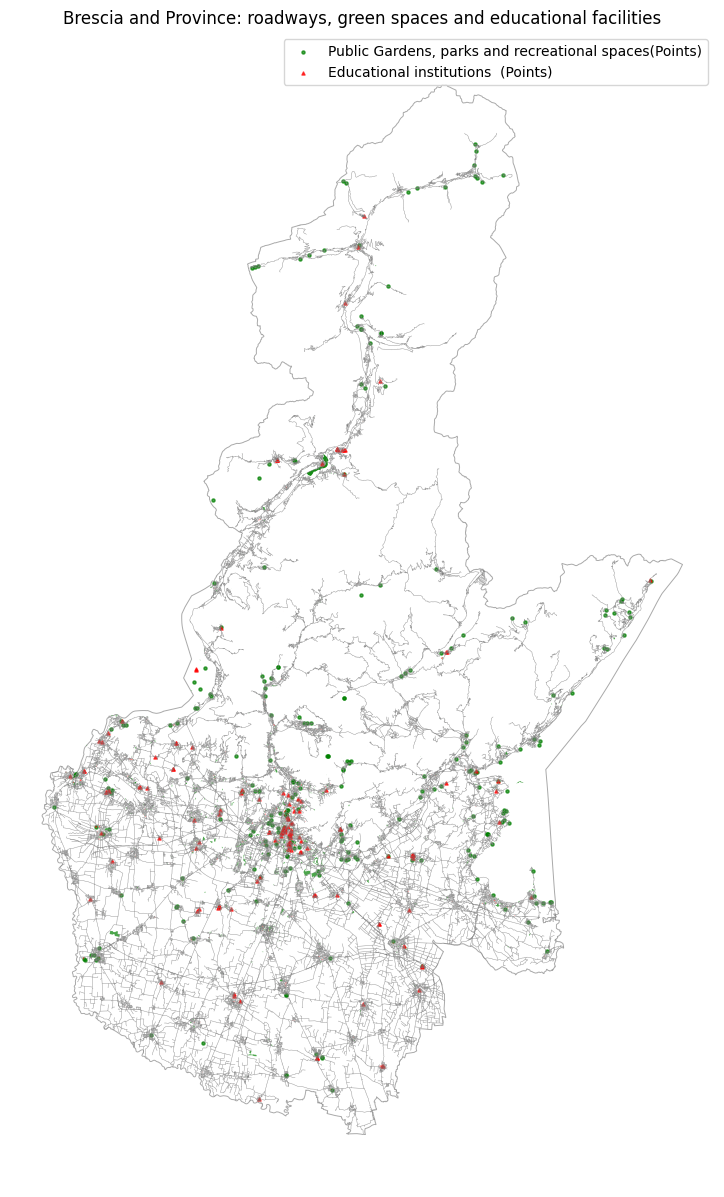

In [ ]:
# Crea una mappa combinata
fig, ax = plt.subplots(figsize=(15, 15))

# Riproietta tutti i dati allo stesso CRS per la visualizzazione
# Usa EPSG:3857 (Web Mercator) che è compatibile con contextily
roads_gdf = roads_gdf.to_crs(epsg=3857)
parks_gdf = parks_gdf.to_crs(epsg=3857)
schools_gdf = schools_gdf.to_crs(epsg=3857)
province_gdf = ox.geocode_to_gdf("Provincia di Brescia, Lombardia, Italia").to_crs(epsg=3857)

# Plotta il contorno della provincia
province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgrey', linewidth=0.7, label='Confine provinciale')

# Plotta le strade come linee
roads_gdf.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.5)

# Plotta i giardini
polygon_parks = parks_gdf[parks_gdf.geom_type.isin(['Polygon', 'MultiPolygon'])]
point_parks = parks_gdf[parks_gdf.geometry.apply(lambda geom: geom.geom_type == 'Point')]
polygon_parks.plot(ax=ax, color='green', alpha=0.7, label='Public Gardens, parks and recreational spaces (Areas)')
point_parks.plot(ax=ax, color='green', marker='o', markersize=5, alpha=0.7, label='Public Gardens, parks and recreational spaces(Points)')

# Plotta le scuole
polygon_schools = schools_gdf[schools_gdf.geom_type.isin(['Polygon', 'MultiPolygon'])]
point_schools = schools_gdf[schools_gdf.geometry.apply(lambda geom: geom.geom_type == 'Point')]
polygon_schools.plot(ax=ax, color='red', alpha=0.5, label='Educational institutions  (Areas)')
point_schools.plot(ax=ax, color='red', marker='^', markersize=5, alpha=0.7, label='Educational institutions  (Points)')


# Legenda (la legenda verrà mostrata solo per gli elementi effettivamente plottati)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')

# Titolo
plt.title('Brescia and Province: roadways, green spaces and educational facilities')

# Nascondi assi
ax.set_axis_off()

# Salva la mappa
map_output = "data/brescia_combined_map_polygons.png"
plt.savefig(map_output, dpi=300, bbox_inches='tight')
print(f"Mappa salvata in {map_output}")

# Mostra la mappa
plt.show()

# Maps with educational facilities and parks (centroids)

<ipython-input-18-8ff065b2fb9e>:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


Mappa salvata in data/brescia_combined_map_points.png


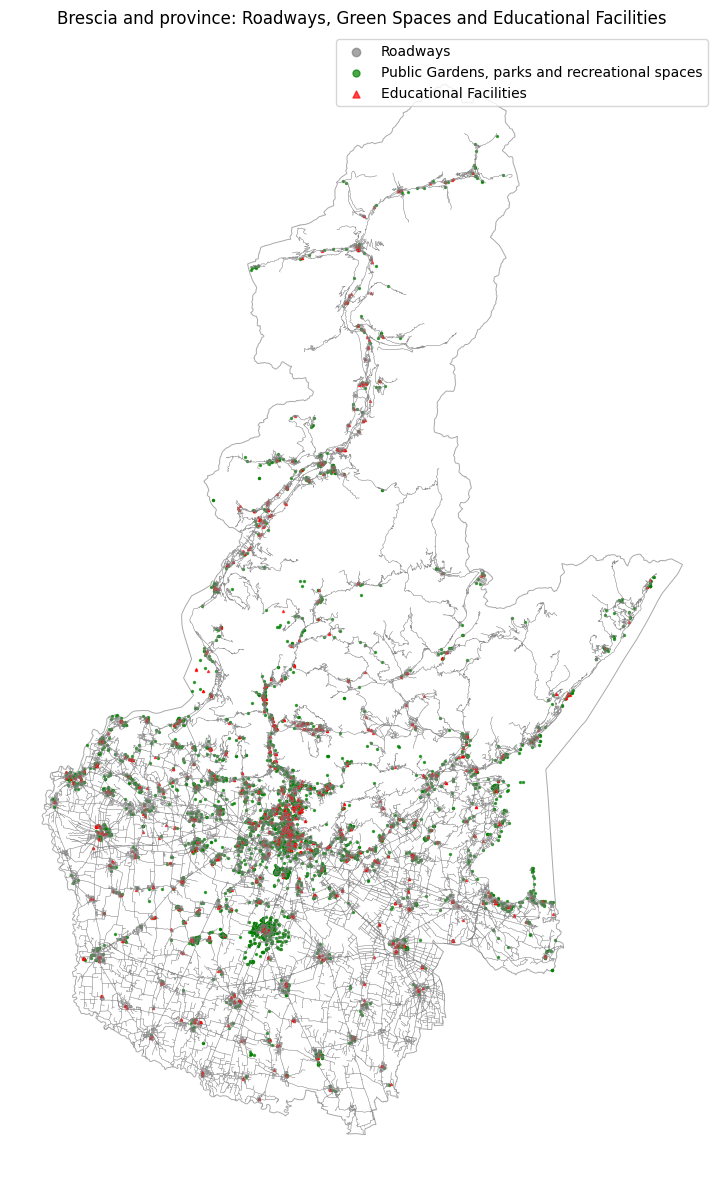

In [ ]:
# Crea una mappa combinata
fig, ax = plt.subplots(figsize=(15, 15))

# Riproietta tutti i dati allo stesso CRS per la visualizzazione
# Usa EPSG:3857 (Web Mercator) che è compatibile con contextily
roads_gdf = roads_gdf.to_crs(epsg=3857)
parks_gdf = parks_gdf.to_crs(epsg=3857)
parks_gdf['geometry'] = parks_gdf.centroid
schools_gdf = schools_gdf.to_crs(epsg=3857)
schools_gdf['geometry'] = schools_gdf.centroid
# Plotta il contorno della provincia
province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgrey', linewidth=0.7, label='Confine provinciale')

# Plotta le strade come linee
roads_gdf.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.7)

# Plotta i giardini come punti
parks_gdf.plot(ax=ax, color='green', marker='o', markersize=2, alpha=0.7)

# Plotta le scuole come punti
schools_gdf.plot(ax=ax, color='red', marker='^', markersize=2, alpha=0.7)

# Legenda
ax.scatter([], [], c='gray', alpha=0.7,label='Roadways')
ax.scatter([], [], c='green', marker='o', s=25, alpha=0.7, label='Public Gardens, parks and recreational spaces')
ax.scatter([], [], c='red', marker='^', s=25, alpha=0.7, label='Educational Facilities')
ax.legend(loc='upper right')

# Titolo
plt.title('Brescia and province: Roadways, Green Spaces and Educational Facilities')

# Nascondi assi
ax.set_axis_off()

# Salva la mappa
map_output = "data/brescia_combined_map_points.png"
plt.savefig(map_output, dpi=300, bbox_inches='tight')
print(f"Mappa salvata in {map_output}")

# Mostra la mappa
plt.show()

# Calculation of travel time

In [ ]:
roads_gdf['maxspeed'].isna().sum()

np.int64(127198)

In [ ]:
roads_gdf['length'].isna().sum()

np.int64(0)

In [ ]:
# Conta i diversi tipi di dato nella colonna maxspeed
maxspeed_types = roads_gdf['maxspeed'].apply(type).value_counts()
print("Tipi di dato nella colonna 'maxspeed':")
print(maxspeed_types)

# Conta i diversi tipi di dato nella colonna length
length_types = roads_gdf['length'].apply(type).value_counts()
print("Tipi di dato nella colonna 'length':")
print(length_types)

Tipi di dato nella colonna 'maxspeed':
maxspeed
<class 'float'>    127202
<class 'str'>       24622
<class 'list'>        492
Name: count, dtype: int64
Tipi di dato nella colonna 'length':
length
<class 'float'>    152316
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re

def kmh_to_mps(kmh):
    return kmh * 1000 / 3600

default_speed = 50
roads_gdf['travel_time'] = 0

for index, row in roads_gdf.iterrows():
    length = row['length']
    maxspeed = row['maxspeed']

    speed_kmh = default_speed  # Impostazione iniziale

    # Caso: lista
    if isinstance(maxspeed, list):
        speeds = []
        for item in maxspeed:
            if isinstance(item, (int, float)) and not pd.isna(item):
                speeds.append(item)
            elif isinstance(item, str):
                matches = re.findall(r'\d+', item)
                if matches:
                    speeds.append(int(matches[0]))
        if len(speeds) > 1:
            speed_kmh = sum(speeds) / len(speeds)
        elif len(speeds) == 1:
            speed_kmh = speeds[0]

    # Caso: stringa
    elif isinstance(maxspeed, str):
        matches = re.findall(r'\d+', maxspeed)
        if len(matches) > 1:
            speeds = [int(m) for m in matches]
            speed_kmh = sum(speeds) / len(speeds)
        elif len(matches) == 1:
            speed_kmh = int(matches[0])

    # Caso: numero (int o float)
    elif isinstance(maxspeed, (int, float)):
        if not pd.isna(maxspeed) and maxspeed > 0:
            speed_kmh = maxspeed

    # Altrimenti, rimane il default

    # Range valido
    if speed_kmh <= 0:
        speed_kmh = default_speed

    speed_mps = kmh_to_mps(speed_kmh)

    if length > 0 and speed_mps > 0:
        travel_time = length / speed_mps
    else:
        travel_time = 1.0

    roads_gdf.at[index, 'travel_time'] = travel_time


<ipython-input-6-86f11dab97b2>:58: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads_gdf.at[index, 'travel_time'] = travel_time
<ipython-input-6-86f11dab97b2>:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4611458621851649' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roads_gdf.at[index, 'travel_time'] = travel_time


In [ ]:
roads_gdf

osmid      highway  \
u           v           key                                                   
21101454    11949943905 0                           1288657358    secondary   
21101569    1689505436  0                             52500982      primary   
            667268119   0                            274968346      primary   
21101583    495306958   0                            523256128      primary   
            1689505654  0                            960745346      primary   
...                                                        ...          ...   
12766882046 12177071339 0                           1378755027  residential   
            12766882045 0                           1378755028  residential   
12791838896 317096809   0               [491467858, 301151613]    secondary   
            387402348   0    [165612498, 301151612, 301151613]    secondary   
            2437060308  0                           1381678737  residential   

                               junction lanes                          name  \
u           v           key                                                   
21101454    11949943905 0    roundabout     2             Via Colli Storici   
21101569    1689505436  0           NaN     2    Strada statale 343 Asolana   
            667268119   0           NaN     2    Strada statale 343 Asolana   
21101583    495306958   0           NaN     2    Strada statale 343 Asolana   
            1689505654  0           NaN     2    Strada statale 343 Asolana   
...                                 ...   ...                           ...   
12766882046 12177071339 0           NaN   NaN                  Via Maggiore   
            12766882045 0           NaN   NaN             Piazza Cappellini   
12791838896 317096809   0           NaN     2  [Via Nazionale, Via Badetto]   
            387402348   0           NaN   NaN                 Via Nazionale   
            2437060308  0           NaN   NaN                           NaN   

                             oneway reversed      length maxspeed     ref  \
u           v           key                                                 
21101454    11949943905 0      True    False    6.404804      NaN     NaN   
21101569    1689505436  0     False    False  105.183682       90   SS343   
            667268119   0      True    False  178.675523       90   SS343   
21101583    495306958   0     False     True   23.426103       90   SS343   
            1689505654  0     False    False  111.429280       90   SS343   
...                             ...      ...         ...      ...     ...   
12766882046 12177071339 0     False     True   29.817951      NaN     NaN   
            12766882045 0      True    False   11.779062      NaN     NaN   
12791838896 317096809   0     False    False  659.510754       50  SPBS42   
            387402348   0     False     True  251.058107      NaN  SPBS42   
            2437060308  0     False    False  420.443737      NaN     NaN   

                                                                      geometry  \
u           v           key                                                      
21101454    11949943905 0    LINESTRING (1179411.159 5691840.259, 1179419.8...   
21101569    1689505436  0    LINESTRING (1163236.08 5678032.112, 1163292.86...   
            667268119   0    LINESTRING (1163236.08 5678032.112, 1163174.47...   
21101583    495306958   0    LINESTRING (1163513.767 5679130.598, 1163511.7...   
            1689505654  0    LINESTRING (1163513.767 5679130.598, 1163520.8...   
...                                                                        ...   
12766882046 12177071339 0    LINESTRING (1148373.704 5777676.033, 1148349.1...   
            12766882045 0    LINESTRING (1148373.704 5777676.033, 1148376.4...   
12791838896 317096809   0    LINESTRING (1150606.071 5779110.553, 1150713.9...   
            387402348   0    LINESTRING (1150606.071 5779110.553, 1150601.5...   
            243

Checking that the variable travel time is of type numeric

In [ ]:
import numpy as np

# Colonna da analizzare
column = 'travel_time'

# Statistiche di base
total_rows = len(roads_gdf)
nan_count = roads_gdf[column].isna().sum()
inf_count = np.isinf(roads_gdf[column]).sum()
negative_count = ((roads_gdf[column] < 0) & (~roads_gdf[column].isna()) & (~np.isinf(roads_gdf[column]))).sum()
zero_count = (roads_gdf[column] == 0).sum()

# Stampa dei risultati
print(f"Totale righe: {total_rows}")
print(f"Valori NaN in '{column}': {nan_count}")
print(f"Valori infiniti in '{column}': {inf_count}")
print(f"Valori negativi in '{column}': {negative_count}")
print(f"Valori zero in '{column}': {zero_count}")


Totale righe: 152312
Valori NaN in 'travel_time': 0
Valori infiniti in 'travel_time': 0
Valori negativi in 'travel_time': 0
Valori zero in 'travel_time': 0


# Penalty if the road is close to a school (< 50 m)

In [ ]:
schools_gdf

geometry       amenity  \
element id                                                          
node    361178476    POINT (1099849.46 5716459.414)  kindergarten   
        387674317   POINT (1106574.493 5724008.575)        school   
        393013593   POINT (1174891.821 5708482.781)  kindergarten   
        454869773   POINT (1147809.603 5769192.519)  kindergarten   
        474598219   POINT (1102294.348 5717393.387)        school   
...                                             ...           ...   
way     1343047802  POINT (1143987.516 5808264.223)                 
        1344430368   POINT (1140436.238 5807002.66)        school   
        1374271850  POINT (1101551.807 5716394.373)                 
        1374365164  POINT (1101499.016 5716380.182)                 
        1387921948  POINT (1200771.295 5749434.141)        school   

                                                                 name leisure  \
element id                                                                      
node    361178476                                                 NaN           
        387674317                                           Accademia           
        393013593                    Scuola Materna Don Angelo Merici           
        454869773                  Scuola dell'Infanzia Maria Bambina           
        474598219                             Scuola Primaria Statale           
...                                                               ...     ...   
way     1343047802                                                NaN           
        1344430368                                                NaN           
        1374271850                                                NaN           
        1374365164                                                NaN           
        1387921948  Scuola primaria e secondaria di primo grado Mo...           

                   access wheelchair operator         addr:city addr:postcode  \
element id                                                                      
node    361178476     NaN        NaN      NaN               NaN           NaN   
        387674317     NaN        NaN      NaN               NaN           NaN   
        393013593     NaN        NaN      NaN               NaN           NaN   
        454869773     NaN        NaN      NaN               NaN           NaN   
        474598219     NaN        NaN      NaN               NaN           NaN   
...                   ...        ...      ...               ...           ...   
way     1343047802    NaN        NaN      NaN               NaN           NaN   
        1344430368    NaN        NaN      NaN               NaN           NaN   
        1374271850    NaN        NaN      NaN               NaN           NaN   
        1374365164    NaN        NaN      NaN               NaN           NaN   
        1387921948    NaN        NaN      NaN  Limone sul Garda           NaN   

                   addr:street  ... highway end_date disused:military  \
element id                      ...                                     
node    361178476          NaN  ...     NaN      NaN              NaN   
        387674317          NaN  ...     NaN      NaN              NaN   
        393013593          NaN  ...     NaN      NaN              NaN   
        454869773          NaN  ...     NaN      NaN              NaN   
        474598219          NaN  ...     NaN      NaN              NaN   
...                        ...  ...     ...      ...              ...   
way     1343047802         NaN  ...     NaN      NaN              NaN   
        1344430368         NaN  ...     NaN      NaN              NaN   
        1374271850         NaN  ...     NaN      NaN              NaN   
        1374365164         NaN  ...     NaN      NaN              NaN   
        1387921948         NaN  ...     NaN      NaN              NaN   

                   social_facility social_facility:for archery boundary  \
element id  

In [ ]:
# 1. Crea un buffer intorno a tutte le strade (se non già fatto)

# Reproietta in metri
roads_gdf = roads_gdf.to_crs(epsg=3857)
schools_gdf = schools_gdf.to_crs(epsg=3857)

threshold = 50  # metri
roads_gdf['geometry_buffer'] = roads_gdf.geometry.buffer(threshold)

# 2. Costruisci spatial index per le scuole
schools_sindex = schools_gdf.sindex

# 3. Funzione per determinare se una strada è vicina a una scuola
def check_school_penalty(row):
    buffer_geom = row['geometry_buffer']

    possible_matches_idx = list(schools_sindex.intersection(buffer_geom.bounds))
    if not possible_matches_idx:
        return row['travel_time'], 0  # nessuna scuola vicina

    possible_schools = schools_gdf.iloc[possible_matches_idx]
    if possible_schools.intersects(buffer_geom).any():
        return row['travel_time'] * 1.5, 1  # penalizzazione
    else:
        return row['travel_time'], 0

# 4. Applica la funzione a tutte le righe (vettorialmente)
roads_gdf[['cost', 'penalization']] = roads_gdf.apply(
    check_school_penalty,
    axis=1,
    result_type='expand'
)


In [ ]:
roads_gdf

osmid      highway  \
u           v           key                                                   
21101454    11949943905 0                           1288657358    secondary   
21101569    1689505436  0                             52500982      primary   
            667268119   0                            274968346      primary   
21101583    495306958   0                            523256128      primary   
            1689505654  0                            960745346      primary   
...                                                        ...          ...   
12766882046 12177071339 0                           1378755027  residential   
            12766882045 0                           1378755028  residential   
12791838896 317096809   0               [491467858, 301151613]    secondary   
            387402348   0    [165612498, 301151612, 301151613]    secondary   
            2437060308  0                           1381678737  residential   

                               junction lanes                          name  \
u           v           key                                                   
21101454    11949943905 0    roundabout     2             Via Colli Storici   
21101569    1689505436  0           NaN     2    Strada statale 343 Asolana   
            667268119   0           NaN     2    Strada statale 343 Asolana   
21101583    495306958   0           NaN     2    Strada statale 343 Asolana   
            1689505654  0           NaN     2    Strada statale 343 Asolana   
...                                 ...   ...                           ...   
12766882046 12177071339 0           NaN   NaN                  Via Maggiore   
            12766882045 0           NaN   NaN             Piazza Cappellini   
12791838896 317096809   0           NaN     2  [Via Nazionale, Via Badetto]   
            387402348   0           NaN   NaN                 Via Nazionale   
            2437060308  0           NaN   NaN                           NaN   

                             oneway reversed      length maxspeed     ref  \
u           v           key                                                 
21101454    11949943905 0      True    False    6.404804      NaN     NaN   
21101569    1689505436  0     False    False  105.183682       90   SS343   
            667268119   0      True    False  178.675523       90   SS343   
21101583    495306958   0     False     True   23.426103       90   SS343   
            1689505654  0     False    False  111.429280       90   SS343   
...                             ...      ...         ...      ...     ...   
12766882046 12177071339 0     False     True   29.817951      NaN     NaN   
            12766882045 0      True    False   11.779062      NaN     NaN   
12791838896 317096809   0     False    False  659.510754       50  SPBS42   
            387402348   0     False     True  251.058107      NaN  SPBS42   
            2437060308  0     False    False  420.443737      NaN     NaN   

                             ... width bridge access tunnel area est_width  \
u           v           key  ...                                             
21101454    11949943905 0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
21101569    1689505436  0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
            667268119   0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
21101583    495306958   0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
            1689505654  0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
...                          ...   ...    ...    ...    ...  ...       ...   
12766882046 12177071339 0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
            12766882045 0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
12791838896 317096809   0    ...   NaN    NaN    NaN    NaN  NaN       NaN   
            387402348   0    ...   NaN    yes    NaN    NaN  NaN       NaN   
            2437060308  0    ...   NaN    NaN    NaN    NaN  Na

In [ ]:
inf_count = np.isinf(roads_gdf['cost']).sum()
print(f"Number of 'inf' values in 'cost' column: {inf_count}")

Number of 'inf' values in 'cost' column: 0


In [ ]:
roads_gdf['penalization'].value_counts()

penalization
0.0    150377
1.0      1935
Name: count, dtype: int64

In [ ]:
parks_gdf

geometry amenity  \
element id                                                    
node    339158057   POINT (1170699.696 5821403.887)           
        372776620   POINT (1152394.085 5792112.165)           
        442364731   POINT (1165405.642 5819398.088)           
        482789712    POINT (1124938.335 5764694.64)           
        496427783    POINT (1158918.12 5818531.219)           
...                                             ...     ...   
way     1382514852  POINT (1139891.546 5696738.357)           
        1382514853    POINT (1142380.639 5696622.3)           
        1385661915  POINT (1134383.332 5709068.846)           
        1386070142  POINT (1136383.169 5705694.733)           
        1389188982  POINT (1197845.546 5744163.991)           

                                    name     leisure     access wheelchair  \
element id                                                                   
node    339158057                    NaN  playground        NaN        NaN   
        372776620                    NaN  playground        NaN        NaN   
        442364731                    NaN  playground        yes        NaN   
        482789712                    NaN  playground        yes        NaN   
        496427783                    NaN  playground  customers        NaN   
...                                  ...         ...        ...        ...   
way     1382514852    Parco Primo Maggio        park        NaN        NaN   
        1382514853  Parco Isola di Vetro        park        NaN        NaN   
        1385661915                   NaN  playground        NaN        NaN   
        1386070142       Parco Martinoni        park        yes        NaN   
        1389188982                   NaN        park        NaN        NaN   

                             operator addr:city addr:postcode addr:street  \
element id                                                                  
node    339158057                 NaN       NaN           NaN         NaN   
        372776620                 NaN       NaN           NaN         NaN   
        442364731                 NaN       NaN           NaN         NaN   
        482789712                 NaN       NaN           NaN         NaN   
        496427783                 NaN       NaN           NaN         NaN   
...                               ...       ...           ...         ...   
way     1382514852                NaN       NaN           NaN         NaN   
        1382514853                NaN       NaN           NaN         NaN   
        1385661915                NaN       NaN           NaN         NaN   
        1386070142  Comune di Brescia       NaN           NaN         NaN   
        1389188982                NaN       NaN           NaN         NaN   

                    ... highway end_date disused:military social_facility  \
element id          ...                                                     
node    339158057   ...     NaN      NaN              NaN             NaN   
        372776620   ...     NaN      NaN              NaN             NaN   
        442364731   ...     NaN      NaN              NaN             NaN   
        482789712   ...     NaN      NaN              NaN             NaN   
        496427783   ...     NaN      NaN              NaN             NaN   
...                 ...     ...      ...              ...             ...   
way     1382514852  ...     NaN      NaN              NaN             NaN   
        1382514853  ...     NaN      NaN              NaN             NaN   
        1385661915  ...     NaN      NaN              NaN             NaN   
        1386070142  ...     NaN      NaN              NaN             NaN   
        1389188982  ...     NaN      NaN              NaN             NaN   

                   social_facility:for archery boundary protect_class  \
element id                                                              
node    339158057                  NaN     NaN      NaN   

In [ ]:
roads_gdf = roads_gdf.to_crs(epsg=3857)
parks_gdf = parks_gdf.to_crs(epsg=3857)

# Crea un spatial index per i parchi
parks_sindex = parks_gdf.sindex

# Funzione per verificare intersezioni e calcolare penalità dei parchi sommata a quella delle scuole
def check_penalty(row):
    buffer_geom = row['geometry_buffer']
    base_cost = row['cost']  # già contiene il valore dopo la penalità delle scuole
    current_penalty = row['penalization']

    # Trova candidati con spatial index
    possible_matches_idx = list(parks_sindex.intersection(buffer_geom.bounds))
    if not possible_matches_idx:
        return base_cost, current_penalty  # nessun parco vicino

    possible_parks = parks_gdf.iloc[possible_matches_idx]
    if possible_parks.intersects(buffer_geom).any():
        return base_cost * 1.5, current_penalty + 1
    else:
        return base_cost, current_penalty

#Applica funzione in modo vettoriale
roads_gdf[['cost', 'penalization']] = roads_gdf.apply(
    check_penalty, axis=1, result_type='expand'
)


In [ ]:
# 5. (Opzionale) Rimuovi colonna temporanea buffer se non serve più
roads_gdf.drop(columns='geometry_buffer', inplace=True)

In [ ]:
roads_gdf.head()

osmid    highway    junction lanes  \
u        v           key                                            
21101454 11949943905 0    1288657358  secondary  roundabout     2   
21101569 1689505436  0      52500982    primary         NaN     2   
         667268119   0     274968346    primary         NaN     2   
21101583 495306958   0     523256128    primary         NaN     2   
         1689505654  0     960745346    primary         NaN     2   

                                                name  oneway reversed  \
u        v           key                                                
21101454 11949943905 0             Via Colli Storici    True    False   
21101569 1689505436  0    Strada statale 343 Asolana   False    False   
         667268119   0    Strada statale 343 Asolana    True    False   
21101583 495306958   0    Strada statale 343 Asolana   False     True   
         1689505654  0    Strada statale 343 Asolana   False    False   

                              length maxspeed    ref  \
u        v           key                               
21101454 11949943905 0      6.404804      NaN    NaN   
21101569 1689505436  0    105.183682       90  SS343   
         667268119   0    178.675523       90  SS343   
21101583 495306958   0     23.426103       90  SS343   
         1689505654  0    111.429280       90  SS343   

                                                                   geometry  \
u        v           key                                                      
21101454 11949943905 0    LINESTRING (1179411.159 5691840.259, 1179419.8...   
21101569 1689505436  0    LINESTRING (1163236.08 5678032.112, 1163292.86...   
         667268119   0    LINESTRING (1163236.08 5678032.112, 1163174.47...   
21101583 495306958   0    LINESTRING (1163513.767 5679130.598, 1163511.7...   
         1689505654  0    LINESTRING (1163513.767 5679130.598, 1163520.8...   

                         width bridge access tunnel area est_width  \
u        v           key                                             
21101454 11949943905 0     NaN    NaN    NaN    NaN  NaN       NaN   
21101569 1689505436  0     NaN    NaN    NaN    NaN  NaN       NaN   
         667268119   0     NaN    NaN    NaN    NaN  NaN       NaN   
21101583 495306958   0     NaN    NaN    NaN    NaN  NaN       NaN   
         1689505654  0     NaN    NaN    NaN    NaN  NaN       NaN   

                          travel_time      cost  penalization  
u        v           key                                       
21101454 11949943905 0       0.461146  0.461146           0.0  
21101569 1689505436  0       4.207347  4.207347           0.0  
         667268119   0       7.147021  7.147021           0.0  
21101583 495306958   0       0.937044  0.937044           0.0  
         1689505654  0       4.457171  4.457171           0.0

In [ ]:
roads_gdf['penalization'].value_counts()

penalization
0.0    142571
1.0      9571
2.0       170
Name: count, dtype: int64

# Mapping penalized roads

<ipython-input-35-9927b70b556e>:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


Mappa salvata in data/brescia_roads_penalization_map.png


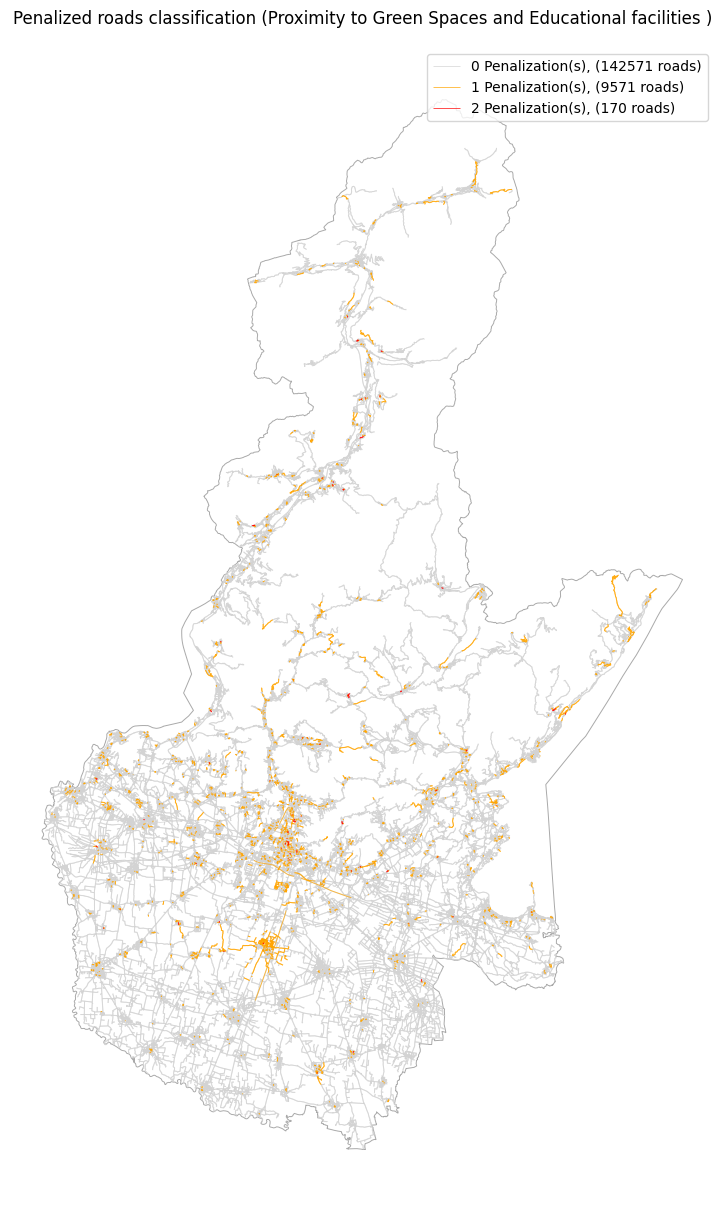

In [ ]:
#penalization counts
penalization_counts = roads_gdf['penalization'].value_counts()

# Definisci i colori per i diversi livelli di penalizzazione
color_map = {0: 'lightgray', 1: 'orange', 2: 'red'}

# Crea la figura e gli assi
fig, ax = plt.subplots(figsize=(15, 15))

# Riproietta i dati al sistema di coordinate per la visualizzazione (Web Mercator)
roads_gdf_webmercator = roads_gdf.to_crs(epsg=3857)

province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, label='Confine provinciale')

for penalization_level, color in color_map.items():
    subset = roads_gdf_webmercator[roads_gdf_webmercator['penalization'] == penalization_level]
    count = penalization_counts.get(penalization_level, 0)  # prendi il numero per quel livello
    subset.plot(ax=ax, color=color, linewidth=0.7, alpha=0.7,
                label=f'{penalization_level} Penalization(s), ({count} roads)')


# Aggiungi la legenda
ax.legend(loc='upper right')

# Aggiungi il titolo
plt.title('Penalized roads classification (Proximity to Green Spaces and Educational facilities )')

# Rimuovi gli assi
ax.set_axis_off()

# Crea i dati della tabella come lista di liste
table_data = [["Penalization", "Number of roads"]]
for level in sorted(color_map.keys()):
    count = penalization_counts.get(level, 0)
    table_data.append([str(level), str(count)])

# Salva la mappa (opzionale)
map_output_penalization = "data/brescia_roads_penalization_map.png"
plt.savefig(map_output_penalization, dpi=300, bbox_inches='tight')
print(f"Mappa salvata in {map_output_penalization}")

# Mostra la mappa
plt.show()

#Focus on road attributes and penalties based on attributes

roads_gdf is a GeoDataFrame containing arcs of the grraph. To work with (u, v, key, data), we work with the graph.

Es:
gdf = ox.geocode_to_gdf("Provincia di Brescia, Lombardia, Italia")
polygon = gdf.geometry.iloc[0]
G = ox.graph_from_polygon(polygon, network_type='drive')

To save the graph:
ox.save_graphml(G, filepath)

In [ ]:
#ESTRARRE VALORI UNICI PER OGNI ATTRIBUTO STRADALE DISPONIBILE

# Appiattire le liste in una colonna
for column in roads_gdf.columns:
    # Controlla se ci sono liste nella colonna
    if roads_gdf[column].apply(lambda x: isinstance(x, list)).any():
        # Appiattisci tutte le liste in un unico array
        flattened_values = [item for sublist in roads_gdf[column] for item in (sublist if isinstance(sublist, list) else [sublist])]
        print(f"Valori unici per la colonna '{column}' (dopo appiattimento):")
        print(pd.Series(flattened_values).unique())
    else:
        # Se la colonna non ha liste, usa .unique() normalmente
        print(f"Valori unici per la colonna '{column}':")
        print(roads_gdf[column].unique())
    print("\n")

Valori unici per la colonna 'osmid' (dopo appiattimento):
[1288657358   52500982  274968346 ... 1339607971 1343569263 1378755028]


Valori unici per la colonna 'highway' (dopo appiattimento):
['secondary' 'primary' 'trunk' 'trunk_link' 'unclassified' 'tertiary'
 'residential' 'motorway_link' 'motorway' 'living_street' 'secondary_link'
 'road' 'primary_link' 'tertiary_link' 'busway' 'crossing' 'rest_area']


Valori unici per la colonna 'junction':
['roundabout' nan 'circular']


Valori unici per la colonna 'lanes' (dopo appiattimento):
['2' '1' nan '3' '7' '4' '0' '5']


Valori unici per la colonna 'name' (dopo appiattimento):
['Via Colli Storici' 'Strada statale 343 Asolana' 'Via Brescia' ...
 'Via Togni' 'Via Chivo' 'Via bassa']


Valori unici per la colonna 'oneway':
[ True False]


Valori unici per la colonna 'reversed' (dopo appiattimento):
[False  True]


Valori unici per la colonna 'length':
[  6.40480364 105.18368214 178.67552298 ...  11.77906198 659.51075377
 420.44373726]


Va

library that are necessary to work with Overpass

In [ ]:
!pip install osmnx requests
import requests
import pandas as pd
import json
from shapely.geometry import shape
from shapely.wkt import loads as wkt_loads
from shapely.ops import unary_union
import geopandas as gpd

In [ ]:
# Definisci la query Overpass per recuperare tutte le strade con il tag "lit"
query = f"""
[out:json][timeout:60];

// Trova l'area della provincia di Brescia (admin_level=6 = provincia)
area["name"="Brescia"]["admin_level"="6"]->.searchArea;

// Cerca strade con tag lit
(
  way["lit"](area.searchArea);
  way["hazmat"](area.searchArea);
  way["surface"](area.searchArea);
  way["bicycle_road"](area.searchArea);
  way["footway"](area.searchArea);
  way["psv"](area.searchArea);
  way["service"](area.searchArea);
  way["smoothness"](area.searchArea);
  way["tracktype"](area.searchArea);

);
out body;
>;
out skel qt;
"""

#psv: Indica se la strada è riservata ai veicoli pubblici (PSV), come autobus o taxi.
#service: Indica il tipo di servizio fornito dalla strada, ad esempio "driveway" (accesso a una proprietà privata), "parking_aisle" (area di parcheggio), ecc.
#tracktype: La tipologia della strada o del sentiero (ad esempio, "grade1" per una strada asfaltata di alta qualità, "grade5" per una pista non asfaltata).

# Esegui la richiesta Overpass API
url = "http://overpass-api.de/api/interpreter"
response = requests.post(url, data={"data": query})

# Verifica che la richiesta abbia avuto successo
if response.status_code != 200:
    raise Exception(f"Errore nella richiesta: {response.status_code}")

# Carica i dati dalla risposta JSON
# Restituisce le strade che hanno ALMENO uno dei tag
data = response.json()


# Filtra gli oggetti "way" dalla risposta
ways = [el for el in data["elements"] if el["type"] == "way"]

# Costruisci un DataFrame con osmid e il valore del tag "lit"
def create_df_for_tag(tag):
    rows = []
    for w in ways:
        tags = w.get("tags", {})
        tag_val = tags.get(tag)

        if tag_val:  # Aggiungi solo se il tag esiste
            rows.append({
                "osmid": w["id"],
                tag: tag_val  # Salva il valore del tag
            })

    return pd.DataFrame(rows)

# Crea i DataFrame per ogni tag
df_surface = create_df_for_tag("surface")
df_hazmat = create_df_for_tag("hazmat")
df_lit = create_df_for_tag("lit")
df_bicycle_road= create_df_for_tag("bicycle_road")
df_footway = create_df_for_tag("footway")
df_psv = create_df_for_tag("psv")
df_service = create_df_for_tag("service")
df_smoothness = create_df_for_tag("smoothness")
df_tracktype = create_df_for_tag("tracktype")


# Visualizza il numero di strade per ciascun tag
print(f"Trovate {len(df_surface)} strade con tag 'surface'")
print(f"Trovate {len(df_hazmat)} strade con tag 'hazmat'")
print(f"Trovate {len(df_lit)} strade con tag 'lit'")
print(f"Trovate {len(df_bicycle_road)} strade con tag 'bicycle_road'")
print(f"Trovate {len(df_footway)} strade con tag 'footway'")
print(f"Trovate {len(df_psv)} strade con tag 'psv'")
print(f"Trovate {len(df_service)} strade con tag 'service'")
print(f"Trovate {len(df_smoothness)} strade con tag 'smoothness'")
print(f"Trovate {len(df_tracktype)} strade con tag 'tracktype'")

print(f"Valori unici per tag 'surface'")
print(df_surface['surface'].unique())
print(f"Valori unici per tag 'hazmat'")
print(df_hazmat['hazmat'].unique())
print(f"Valori unici per tag 'lit'")
print(df_lit['lit'].unique())
print(f"Valori unici per tag 'bicycle_road'")
print(df_bicycle_road['bicycle_road'].unique())
print(f"Valori unici per tag 'footway'")
print(df_footway['footway'].unique())
print(f"Valori unici per tag 'psv'")
print(df_psv['psv'].unique())
print(f"Valori unici per tag 'service'")
print(df_service['service'].unique())
print(f"Valori unici per tag 'smoothness'")
print(df_smoothness['smoothness'].unique())
print(f"Valori unici per tag 'tracktype'")
print(df_tracktype['tracktype'].unique())


Trovate 80221 strade con tag 'surface'
Trovate 64 strade con tag 'hazmat'
Trovate 9503 strade con tag 'lit'
Trovate 9 strade con tag 'bicycle_road'
Trovate 4278 strade con tag 'footway'
Trovate 486 strade con tag 'psv'
Trovate 12281 strade con tag 'service'
Trovate 3769 strade con tag 'smoothness'
Trovate 18819 strade con tag 'tracktype'
Valori unici per tag 'surface'
['sett' 'asphalt' 'gravel' 'concrete' 'ground' 'unpaved' 'fine_gravel'
 'pebblestone' 'sand' 'wood' 'paved' 'paving_stones' 'compacted'
 'unhewn_cobblestone' 'grass' 'stone' 'dirt' 'metal' 'concrete:plates'
 'ice' 'rock' 'concrete:lanes' 'paving_stones:lanes' 'artificial_turf'
 'grass_paver' 'earth' 'cobblestone:flattened:lanes' 'clay' 'stone:lanes'
 'metal_grid' 'tartan' 'rubber' 'acrylic' 'turf' 'cobblestone:lanes'
 'asphalt:lanes' 'very_bad' 'mud' 'marmor' 'cobblestone' 'rubbercrumb'
 'plastic' 'grass_paver:lanes' 'legno;metallo' 'sett:lanes' 'dirt;sand'
 'logs' 'dirt/sand' 'stone_plates' 'erba sintetica'
 'asfalto_e_a

roads_gdf_temp = roads_gdf.copy() #qui ho creato una copia per non fare casini con dataframe originale
roads_gdf_temp = roads_gdf_temp.explode("osmid").reset_index()  # ← questo è necessario per associare un solo osmid per riga, utile per i merge con altri DataFrame.

dfs = [df_surface, df_hazmat, df_lit, df_bicycle_road, df_footway,
       df_psv, df_service, df_smoothness, df_tracktype]

Questo crea un DataFrame df_all_tags che contiene tutti i nuovi attributi per ogni osmid.
from functools import reduce
df_all_tags = reduce(lambda left, right: pd.merge(left, right, on='osmid', how='outer'), dfs)

Unisci al GeoDataFrame esistente. Ora ogni riga del tuo GeoDataFrame ha anche i nuovi attributi collegati all'osmid.
roads_gdf_merged = roads_gdf_temp.merge(df_all_tags, on='osmid', how='left')


roads_gdf è stato esploso e deve essere ricostruito.
Definiamo un dizionario di aggregazione, ovvero vogliamo ricostruirli ricomponendo la lista di OSM ID per arco.
agg_dict = {
    'geometry': 'first',
    'osmid': lambda x: list(x),
}

Aggiungi tutti i nuovi attributi presenti in df_all_tags (tranne 'osmid') con funzione personalizzata
for col in df_all_tags.columns:
    if col != 'osmid':
        agg_dict[col] = lambda x: next((v for v in x if pd.notna(v)), None)

Aggiungi tutte le colonne originali di roads_gdf che non sono già nel dizionario (ora contiene solo i nuovi tag)
for col in roads_gdf.columns:
    if col not in agg_dict and col not in ['u', 'v', 'key']:
        agg_dict[col] = lambda x: x.dropna().iloc[0] if x.dropna().size > 0 else None #Questa funzione prende la prima occorrenza non nulla in una colonna durante il groupby, oppure restituisce None se tutti i valori sono NaN.

In [ ]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from functools import reduce

# 1. Crea una copia per non toccare l'originale
roads_gdf_temp = roads_gdf.copy()

# 2. Esplodi la lista degli osmids (un osmid per riga)
roads_gdf_temp = roads_gdf_temp.explode("osmid").reset_index()

# 3. Converte gli osmid in stringa per evitare errori di merge
roads_gdf_temp['osmid'] = roads_gdf_temp['osmid'].astype(str)

# 4. Prepara i DataFrame dei tag da unire
dfs = [df_surface, df_hazmat, df_lit, df_bicycle_road, df_footway,
       df_psv, df_service, df_smoothness, df_tracktype]

# 5. Converte anche qui gli osmid in stringa per uniformità
for df in dfs:
    df['osmid'] = df['osmid'].astype(str)

# 6. Unione di tutti i tag in un unico DataFrame
df_all_tags = reduce(lambda left, right: pd.merge(left, right, on='osmid', how='outer'), dfs)

# 7. Merge tra strade esplose e tag, sulla colonna 'osmid'
roads_gdf_merged = roads_gdf_temp.merge(df_all_tags, on='osmid', how='left')

# 8. Ricostruisci la lista di osmids per ogni arco (raggruppa per u-v-key)
agg_dict = {
    'geometry': 'first',
    'osmid': lambda x: list(x),
}

# 9. Aggiungi tutti i nuovi tag (escludendo 'osmid')
for col in df_all_tags.columns:
    if col != 'osmid':
        agg_dict[col] = lambda x: next((v for v in x if pd.notna(v)), None)

# 10. Aggiungi tutte le colonne originali non ancora gestite
for col in roads_gdf.columns:
    if col not in agg_dict and col not in ['u', 'v', 'key']:
        agg_dict[col] = lambda x: x.dropna().iloc[0] if x.dropna().size > 0 else None

# 11. Ricostruzione del GeoDataFrame raggruppato per arco
roads_gdf_original = roads_gdf_merged.groupby(['u', 'v', 'key'], as_index=False).agg(agg_dict)

# 12. Riattiva la geometria
roads_gdf_original = roads_gdf_original.set_geometry("geometry")

# (Opzionale) Controllo finale
print("Colonne disponibili:", roads_gdf_original.columns.tolist())
print("Inf in cost:", roads_gdf_original['cost'].replace([np.inf, -np.inf], pd.NA).isna().sum())


Colonne disponibili: ['u', 'v', 'key', 'geometry', 'osmid', 'surface', 'hazmat', 'lit', 'bicycle_road', 'footway', 'psv', 'service', 'smoothness', 'tracktype', 'highway', 'junction', 'lanes', 'name', 'oneway', 'reversed', 'length', 'maxspeed', 'ref', 'width', 'bridge', 'access', 'tunnel', 'area', 'est_width', 'travel_time', 'geometry_buffer', 'cost', 'penalization']
Inf in cost: 0


In [ ]:
roads_gdf_original.head()

u           v  key  \
0   9207028   360988919    0   
1   9207184     9207028    0   
2   9207184   262656471    0   
3  13892037  2454060867    0   
4  13892037  6807864835    0   

                                            geometry  \
0  LINESTRING (1140285.33 5701158.479, 1140409.05...   
1  LINESTRING (1139281.684 5700615.513, 1139321.0...   
2  LINESTRING (1139281.684 5700615.513, 1139313.4...   
3  LINESTRING (1165028.725 5820333.473, 1165020.7...   
4  LINESTRING (1165028.725 5820333.473, 1165055.7...   

                                       osmid  surface hazmat        lit  \
0                                 [13055021]  asphalt   None         no   
1                      [494861789, 13055037]  asphalt   None  automatic   
2  [34493848, 24229274, 494861790, 34493847]  asphalt   None       None   
3                                [297697902]  asphalt   None       None   
4                                 [30655452]  asphalt   None       None   

  bicycle_road footway  ...   ref width bridge access tunnel  area est_width  \
0         None    None  ...    A4  None   None   None   None  None      None   
1         None    None  ...  None  None   None   None   None  None      None   
2         None    None  ...  None  None    yes   None   None  None      None   
3         None    None  ...  SS42  None   None   None   None  None      None   
4         None    None  ...  SS42  None   None    yes   None  None      None   

  travel_time        cost penalization  
0  186.982441  186.982441          0.0  
1   47.305046   47.305046          0.0  
2   76.536461   76.536461          0.0  
3    6.223110    6.223110          0.0  
4    1.455255    1.455255          0.0  

[5 rows x 32 columns]

In [ ]:
roads_gdf_original.isna().sum()

u                    0
v                    0
key                  0
geometry             0
osmid                0
surface          78179
hazmat          152206
lit             139818
bicycle_road    152306
footway         152294
psv             151369
service         152312
smoothness      150468
tracktype       151727
highway              0
junction        143450
lanes           117360
name             44767
oneway               0
reversed             0
length               0
maxspeed        127198
ref             137136
width           137772
bridge          148956
access          150554
tunnel          151346
area            152305
est_width       152308
travel_time          0
cost                 0
penalization         0
dtype: int64

Con il codice seguente:
* 'surface': Gestito con pd.notna(x). Se x è NaN, la condizione restituirà False e il valore risultante sarà 0. -->  NaN non vengono considerati "rischiosi" e restituiscono 0.
* 'hazmat' -->  NaN non vengono considerati "rischiosi" e restituiscono 0.
* 'Footway' e 'PSV' (strada pedonale e trasporti pubblici) -->  NaN non vengono considerati "rischiosi" e restituiscono 0.
* 'service' -->  NaN non vengono considerati "rischiosi" e restituiscono 0.
* 'tracktype' e 'smoothness' -->  NaN non vengono considerati "rischiosi" e restituiscono 0.
* ' lanes' --> Se il valore è NaN o non è convertibile, la funzione restituirà 1 (rischioso).
* 'width' -->  Se il valore è NaN, la funzione restituirà 0.
* 'bridge' --> Se il valore è NaN, la funzione restituirà 0.
* 'acces' --> Se il valore è NaN, la funzione restituirà 0.
* 'tunnel' --> Se il valore è NaN, la funzione restituirà 0.
* 'near_school' --> Se il valore è NaN, la funzione restituirà 0.

In [ ]:
#TAG CLEANING  - SURFACE

#Lista dei valori considerati rischiosi
risky_surfaces = [
    'gravel', 'fine_gravel', 'dirt', 'sand', 'mud', 'ground', 'unpaved', 'earth', 'clay',
    'stone', 'rock', 'logs',
    'grass', 'turf', 'artificial_turf', 'grass_paver', 'grass_paver:lanes',
    'ice', 'metal', 'metal_grid', 'rubber', 'rubbercrumb', 'plastic', 'wood',
    'unhewn_cobblestone', 'cobblestone', 'cobblestone:lanes', 'cobblestone:flattened:lanes',
    'porphyry', 'sas', 'pietraia',
    'asfalto,sterrato,pavimentato..', 'dirt/sand', 'dirt;sand', 'legno;metallo', 'erba sintetica'
]

# Crea la colonna binaria
roads_gdf_original['risk_surface'] = roads_gdf_original['surface'].apply(
    lambda x: 1 if pd.notna(x) and x.strip().lower() in risky_surfaces else 0
)

#TAG CLEANING  - HAZMAT

# hazard
roads_gdf_original['risk_hazmat'] = roads_gdf_original['hazmat'].apply(lambda x: 1 if x == 'no' else 0)

#TAG CLEANING  - LIT

roads_gdf_original['risk_lit'] = roads_gdf_original['lit'].apply(lambda x: 1 if x == 'no' else 0)


#TAG CLEANING  - BYCICLE ROAD
# bicycle road
roads_gdf_original['risk_bicycle_road'] = roads_gdf_original['bicycle_road'].apply(lambda x: 1 if x == 'yes' else 0)

#TAG CLEANING  - FOOTWAT
# footway
roads_gdf_original['risk_footway'] = roads_gdf_original['footway'].apply(lambda x: 1 if pd.notna(x) else 0)

#TAG CLEANING  - PSV
# psv
roads_gdf_original['risk_psv'] = roads_gdf_original['psv'].apply(lambda x: 1 if pd.notna(x) else 0)

#TAG CLEANING  - SERVICE
# service
risky_service_vals = {'driveway', 'parking_aisle', 'alley', 'crossover', 'spur', 'siding', 'emergency_access'}
roads_gdf_original['risk_service'] = roads_gdf_original['service'].apply(lambda x: 1 if x in risky_service_vals else 0)

#TAG CLEANING  - SMOOTHNESS
# smoothness
risky_smoothness = {'bad', 'very_bad', 'horrible', 'very_horrible', 'impassable'}
roads_gdf_original['risk_smoothness'] = roads_gdf_original['smoothness'].apply(lambda x: 1 if x in risky_smoothness else 0)

#TAG CLEANING  - TRACKTYPE
# tracktype
risky_track = {'grade3', 'grade4', 'grade5', 'fixme'}
roads_gdf_original['risk_tracktype'] = roads_gdf_original['tracktype'].apply(lambda x: 1 if x in risky_track else 0)


# TAG CLEANING - HIGHWAY (type : list of strings !! we need the function that checks if at least on of the strings is risky or not)
risky_highways = {'residential', 'living_street', 'unclassified', 'road', 'busway', 'crossing', 'rest_area'}
def is_risky_highway(x):
    if isinstance(x, list):
        return int(any(item in risky_highways for item in x))
    return int(x in risky_highways)

roads_gdf_original['risk_highway'] = roads_gdf_original['highway'].apply(is_risky_highway)


# TAG CLEANING - LANES (type : list of strings !! we need the function that checks if at least on of the strings is risky or not)
#moreover, we also need to transform the value from strings into float)

def clean_lanes(x):
    try:
        # Se è una lista, prendi il primo valore utile convertibile
        if isinstance(x, list):
            x = x[0] if x else None
        x = float(x)
        return 1 if x <= 1 else 0
    except:
        return 1  # Tratta come rischioso se non interpretabile

roads_gdf_original['risk_lanes'] = roads_gdf_original['lanes'].apply(clean_lanes)

#TAG CLEANING -  WIDTH

def parse_width(val):
    try:
        return float(str(val).replace(' m', '').replace(';', '').split()[0])
    except:
        return np.nan

roads_gdf_original['width_float'] = roads_gdf_original['width'].apply(parse_width)
roads_gdf_original['risk_width'] = roads_gdf_original['width_float'].apply(lambda x: 1 if x < 3.5 else 0)


# TAG CLEANING - BRIDGE
roads_gdf_original['risk_bridge'] = roads_gdf_original['bridge'].apply(
    lambda x: 1 if isinstance(x, list) and any(val != 'no' for val in x) #assegna 1 se almeno uno degli elementi della lista è diverso da no
              else 1 if pd.notna(x) and x != 'no' #assegna 1 se l'elemento è diverso da no e non è un Nan
              else 0
)


# TAG CLEANING - ACCESS
restricted_access = {'no', 'residents', 'customers', 'delivery', 'destination', 'permit', 'bus', 'agricultural'}

def is_risky_access(x):
    if isinstance(x, list):
        return int(any(item in restricted_access for item in x))
    if pd.isna(x):
        return 0
    return int(x in restricted_access) #int(True) → 1 e int(False) → 1


roads_gdf_original['risk_access'] = roads_gdf_original['access'].apply(is_risky_access)

# TAG CLEANING - TUNNEL
roads_gdf_original['risk_tunnel'] = roads_gdf_original['tunnel'].apply(lambda x: 1 if x in ['yes', 'building_passage', 'covered', 'avalanche_protector'] else 0)


In [ ]:
roads_gdf_original.isna().sum()

u                         0
v                         0
key                       0
geometry                  0
osmid                     0
surface               78179
hazmat               152206
lit                  139818
bicycle_road         152306
footway              152294
psv                  151369
service              152312
smoothness           150468
tracktype            151727
highway                   0
junction             143450
lanes                117360
name                  44767
oneway                    0
reversed                  0
length                    0
maxspeed             127198
ref                  137136
width                137772
bridge               148956
access               150554
tunnel               151346
area                 152305
est_width            152308
travel_time               0
cost                      0
penalization              0
risk_surface              0
risk_hazmat               0
risk_lit                  0
risk_bicycle_road         0
risk_footway              0
risk_psv                  0
risk_service              0
risk_smoothness           0
risk_tracktype            0
risk_highway              0
risk_lanes                0
width_float          138138
risk_width                0
risk_bridge               0
risk_access               0
risk_tunnel               0
dtype: int64

In [ ]:
col_to_drop = ['surface', 'hazmat', 'lit','bicycle_road', 'footway', 'psv', 'service', 'smoothness', 'tracktype', 'highway', 'junction', 'lanes', 'name', 'oneway', 'reversed', 'width','ref', 'bridge', 'access', 'tunnel', 'area', 'est_width', 'width_float']

roads_gdf_original = roads_gdf_original.drop(columns = col_to_drop)

#Creazione RISK-SCORE per attributi stradali

In [ ]:

# COME CI COMPORTIAMO CON STRADE VIETATE PER NORMATIVA?
# Definisci i rischi "bloccanti" per le strade vietate per normativa: vietate a mezzi, pedonali o ciclabili, ZTL o strade private
blocking_conditions = (
    (roads_gdf_original['risk_hazmat'] == 1) |
    (roads_gdf_original['risk_bicycle_road'] == 1) |
    (roads_gdf_original['risk_footway'] == 1) |
    (roads_gdf_original['risk_access'] == 1) |
    (roads_gdf_original['risk_psv'] == 1)
)

#OPZIONE 1
roads_gdf_original['excluded'] = blocking_conditions.astype(int)




In [ ]:
sum_excluded= roads_gdf_original['excluded'].sum()

In [ ]:
#esclusi risk_access, risk_hazmat, risk_byicle_road, risk_psv, risk_footway perchè sono strade proprio vietate

risk_weights = {
    'risk_surface': 0.15,
    'risk_lit': 0.05,
    'risk_service': 0.1,
    'risk_smoothness': 0.1,
    'risk_tracktype': 0.05,
    'risk_highway': 0.15,
    'risk_lanes': 0.1,
    'risk_width': 0.1,
    'risk_bridge': 0.05,
    'risk_tunnel': 0.15,
}

# Filtra le strade percorribili
valid_roads_gdf = roads_gdf_original[roads_gdf_original['excluded'] == 0].copy()

# Calcola punteggio di rischio
valid_roads_gdf['risk_score'] = sum(
    valid_roads_gdf[col] * weight for col, weight in risk_weights.items()
)


<ipython-input-48-6aa0d3610b2e>:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


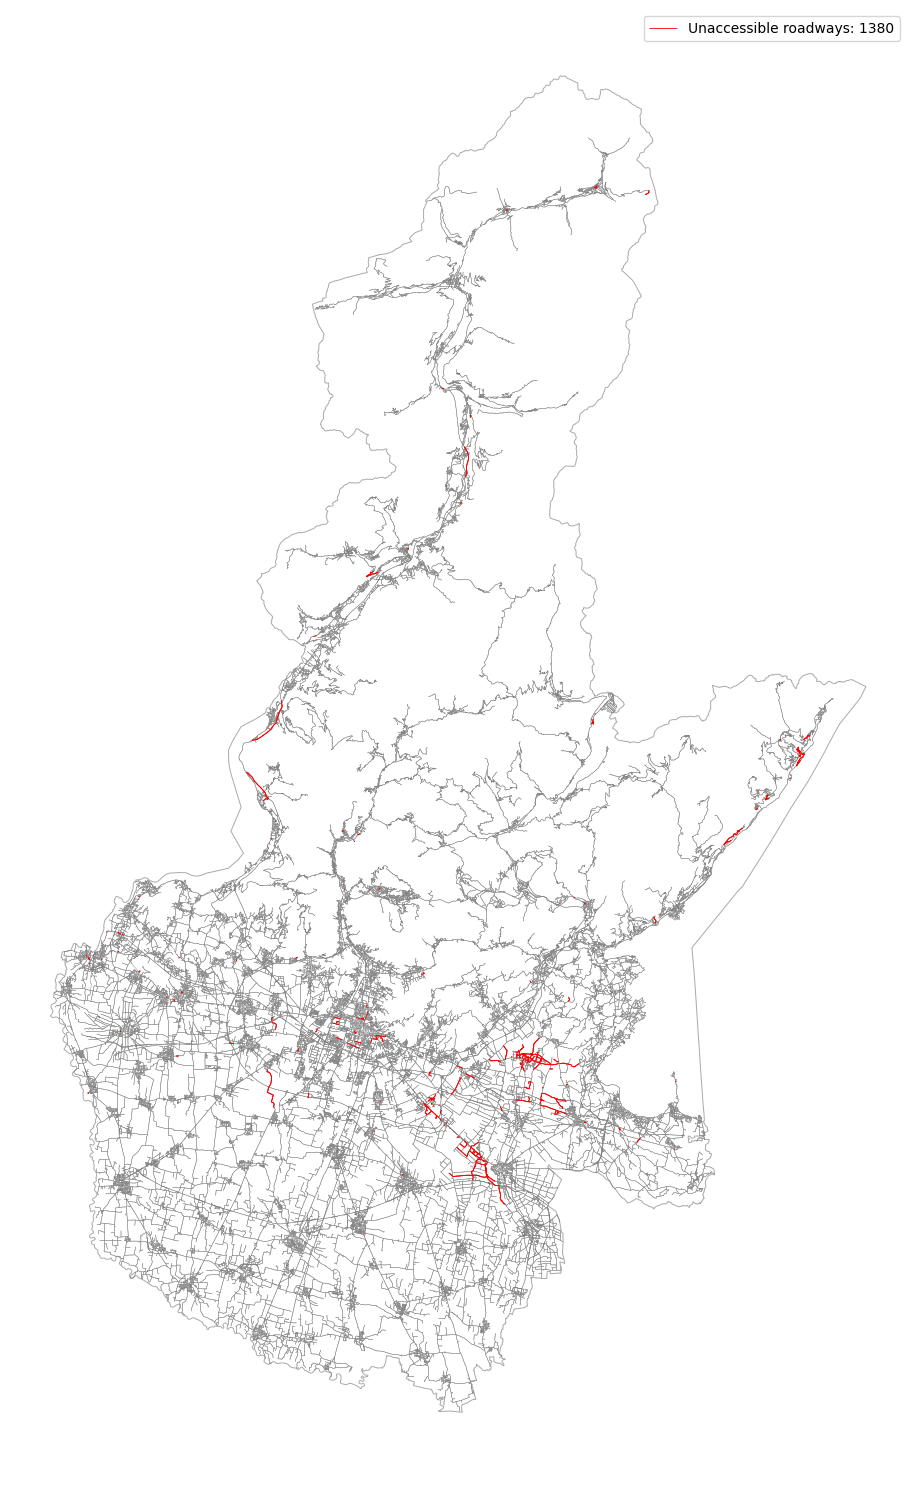

In [ ]:
import matplotlib.pyplot as plt

# Colora le strade vietate in rosso, le altre in grigio chiaro
fig, ax = plt.subplots(figsize=(15, 15))

province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, label='Confine provinciale')

roads_gdf_original.plot(
    ax=ax, color='grey', linewidth=0.3)


# Strade con surface = 'gravel'
roads_gdf_original[roads_gdf_original['excluded'] == 1].plot(
    ax=ax, color='red', linewidth=0.6, label= f"Unaccessible roadways: {sum_excluded}" #cause hazmat, psv, footway, bycicle_road, ztl
)

ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

<ipython-input-65-0143c1004cac>:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


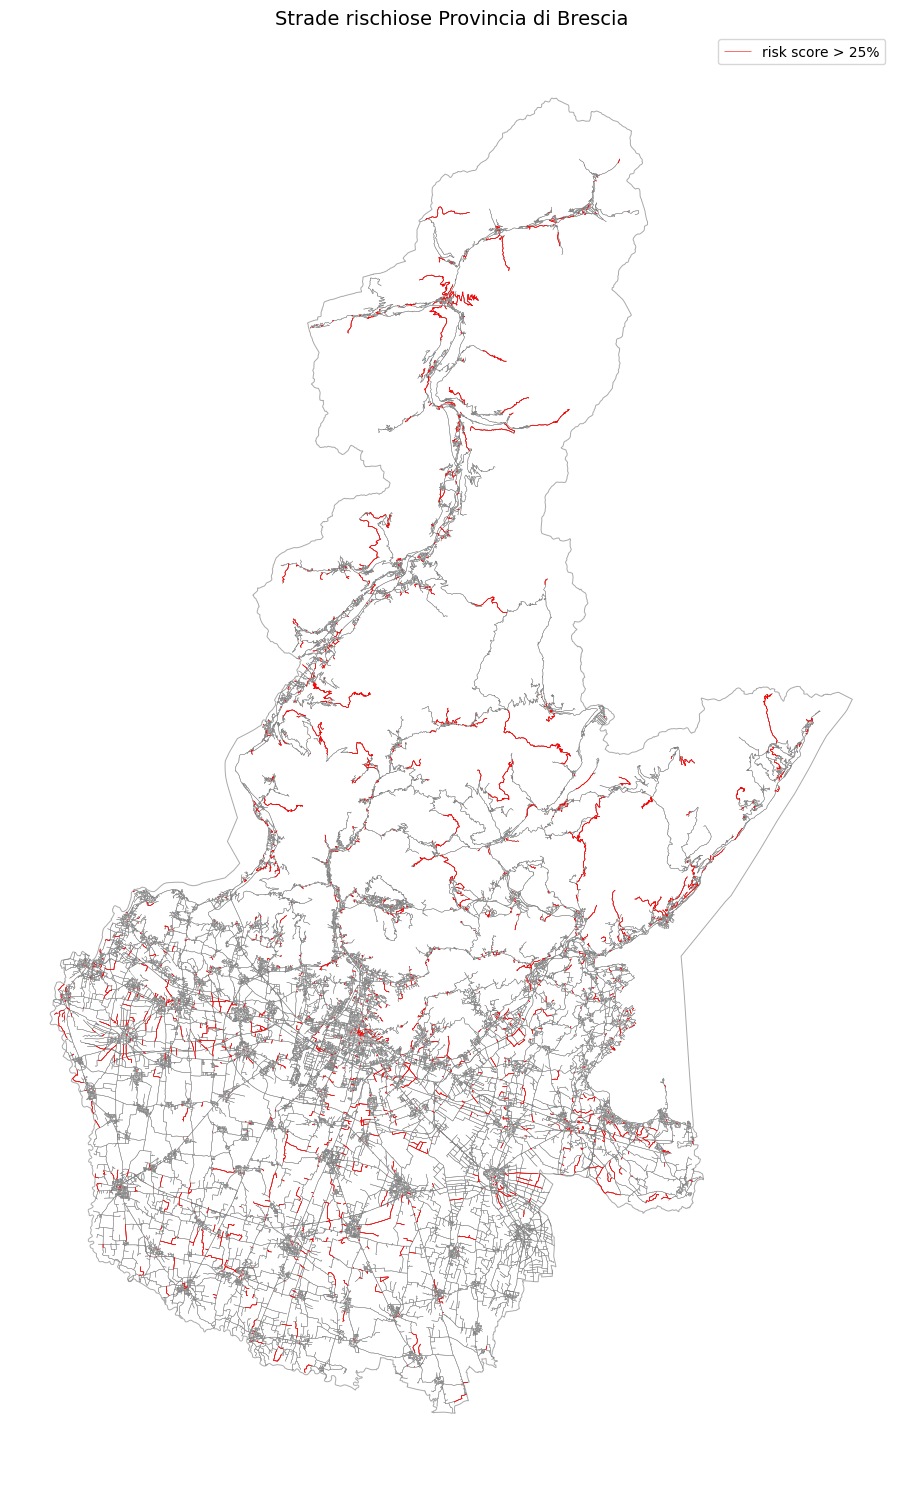

In [ ]:
# Colora le strade con gravel in rosso, le altre in grigio chiaro
fig, ax = plt.subplots(figsize=(15, 15))
#mappa di sfondo: gdf_projected.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, label='Confine provinciale')
roads_gdf_original.plot(
    ax=ax, color='grey', linewidth=0.3)


# Strade con surface = 'gravel'
valid_roads_gdf[valid_roads_gdf['risk_score'] > 0.25].plot(
    ax=ax, color='red', linewidth=0.4, label='risk score > 25%'
)

ax.set_title("Strade rischiose Provincia di Brescia", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
count = (valid_roads_gdf['risk_score'] > 0.25).sum()
print(f"Number of road segments with risk_score > 0.25: {count}")


Number of road segments with risk_score > 0.25: 5035


In [ ]:
valid_roads_gdf.isna().sum()

u                         0
v                         0
key                       0
geometry                  0
osmid                     0
length                    0
maxspeed             126806
travel_time               0
cost                      0
penalization              0
risk_surface              0
risk_hazmat               0
risk_lit                  0
risk_bicycle_road         0
risk_footway              0
risk_psv                  0
risk_service              0
risk_smoothness           0
risk_tracktype            0
risk_highway              0
risk_lanes                0
risk_width                0
risk_bridge               0
risk_access               0
risk_tunnel               0
excluded                  0
risk_score                0
dtype: int64

In [ ]:
inf_count = np.isinf(valid_roads_gdf['cost']).sum()
print(f"Number of 'inf' values in 'cost' column: {inf_count}")

Number of 'inf' values in 'cost' column: 0


In [ ]:
valid_roads_gdf['cost'] = valid_roads_gdf['cost'] * (1 + valid_roads_gdf['risk_score'])


In [ ]:
valid_roads_gdf.head()

u           v  key  \
0   9207028   360988919    0   
1   9207184     9207028    0   
2   9207184   262656471    0   
3  13892037  2454060867    0   
4  13892037  6807864835    0   

                                            geometry  \
0  LINESTRING (1140285.33 5701158.479, 1140409.05...   
1  LINESTRING (1139281.684 5700615.513, 1139321.0...   
2  LINESTRING (1139281.684 5700615.513, 1139313.4...   
3  LINESTRING (1165028.725 5820333.473, 1165020.7...   
4  LINESTRING (1165028.725 5820333.473, 1165055.7...   

                                       osmid       length      maxspeed  \
0                                 [13055021]  6752.143716           130   
1                      [494861789, 13055037]   854.118891      [50, 80]   
2  [34493848, 24229274, 494861790, 34493847]  1204.740596  [50, 40, 80]   
3                                [297697902]    86.432078          None   
4                                 [30655452]    20.211871          None   

   travel_time        cost  penalization  ...  risk_smoothness  \
0   186.982441  196.331563           0.0  ...                0   
1    47.305046   52.035551           0.0  ...                0   
2    76.536461   80.363284           0.0  ...                0   
3     6.223110    6.223110           0.0  ...                0   
4     1.455255    1.455255           0.0  ...                0   

   risk_tracktype  risk_highway  risk_lanes  risk_width  risk_bridge  \
0               0             0           0           0            0   
1               0             0           1           0            0   
2               0             0           0           0            1   
3               0             0           0           0            0   
4               0             0           0           0            0   

   risk_access  risk_tunnel  excluded  risk_score  
0            0            0         0        0.05  
1            0            0         0        0.10  
2            0            0         0        0.05  
3            0            0         0        0.00  
4            0            0         0        0.00  

[5 rows x 27 columns]

In [ ]:
inf_count = np.isinf(valid_roads_gdf['cost']).sum()
print(f"Number of 'inf' values in 'cost' column: {inf_count}")

Number of 'inf' values in 'cost' column: 0


MATRICE

In [ ]:
valid_roads_gdf.head()

u           v  key  \
0   9207028   360988919    0   
1   9207184     9207028    0   
2   9207184   262656471    0   
3  13892037  2454060867    0   
4  13892037  6807864835    0   

                                            geometry  \
0  LINESTRING (1140285.33 5701158.479, 1140409.05...   
1  LINESTRING (1139281.684 5700615.513, 1139321.0...   
2  LINESTRING (1139281.684 5700615.513, 1139313.4...   
3  LINESTRING (1165028.725 5820333.473, 1165020.7...   
4  LINESTRING (1165028.725 5820333.473, 1165055.7...   

                                       osmid       length      maxspeed  \
0                                 [13055021]  6752.143716           130   
1                      [494861789, 13055037]   854.118891      [50, 80]   
2  [34493848, 24229274, 494861790, 34493847]  1204.740596  [50, 40, 80]   
3                                [297697902]    86.432078          None   
4                                 [30655452]    20.211871          None   

   travel_time        cost  penalization  ...  risk_smoothness  \
0   186.982441  196.331563           0.0  ...                0   
1    47.305046   52.035551           0.0  ...                0   
2    76.536461   80.363284           0.0  ...                0   
3     6.223110    6.223110           0.0  ...                0   
4     1.455255    1.455255           0.0  ...                0   

   risk_tracktype  risk_highway  risk_lanes  risk_width  risk_bridge  \
0               0             0           0           0            0   
1               0             0           1           0            0   
2               0             0           0           0            1   
3               0             0           0           0            0   
4               0             0           0           0            0   

   risk_access  risk_tunnel  excluded  risk_score  
0            0            0         0        0.05  
1            0            0         0        0.10  
2            0            0         0        0.05  
3            0            0         0        0.00  
4            0            0         0        0.00  

[5 rows x 27 columns]

# MATRICE dei costi per essere inserita al VRP

In [ ]:
#Costruisci il grafo
import networkx as nx

G = nx.MultiDiGraph()

for _, row in valid_roads_gdf.iterrows():
    G.add_edge(
        row['u'],
        row['v'],
        weight=row['cost'],
        geometry=row['geometry']
    )

from shapely.geometry import Point
import geopandas as gpd

lats = [45.5557508, 45.5173032, 45.6752766, 45.4104244, 45.4724484, 45.6052090,
        45.4570527, 45.3564514, 45.5886191, 45.6000908, 45.6629423, 45.5380671,
        45.5643032, 45.4027300]
lons = [10.2333866, 10.2367065, 10.1838538, 10.4087873, 10.5210075, 10.5222784,
        10.4981922, 10.1459897, 10.4399889, 9.8859103, 10.0521876, 9.9340234,
        9.9981402, 9.9265984]

depot_lat = 45.486074
depot_lon = 10.261607

points = [Point(lon, lat) for lon, lat in zip(lons, lats)]
points.append(Point(depot_lon, depot_lat))  # aggiungi il deposito

poi_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326").to_crs(3857) #I nodi del grafo stradale più vicini a ciascun punto


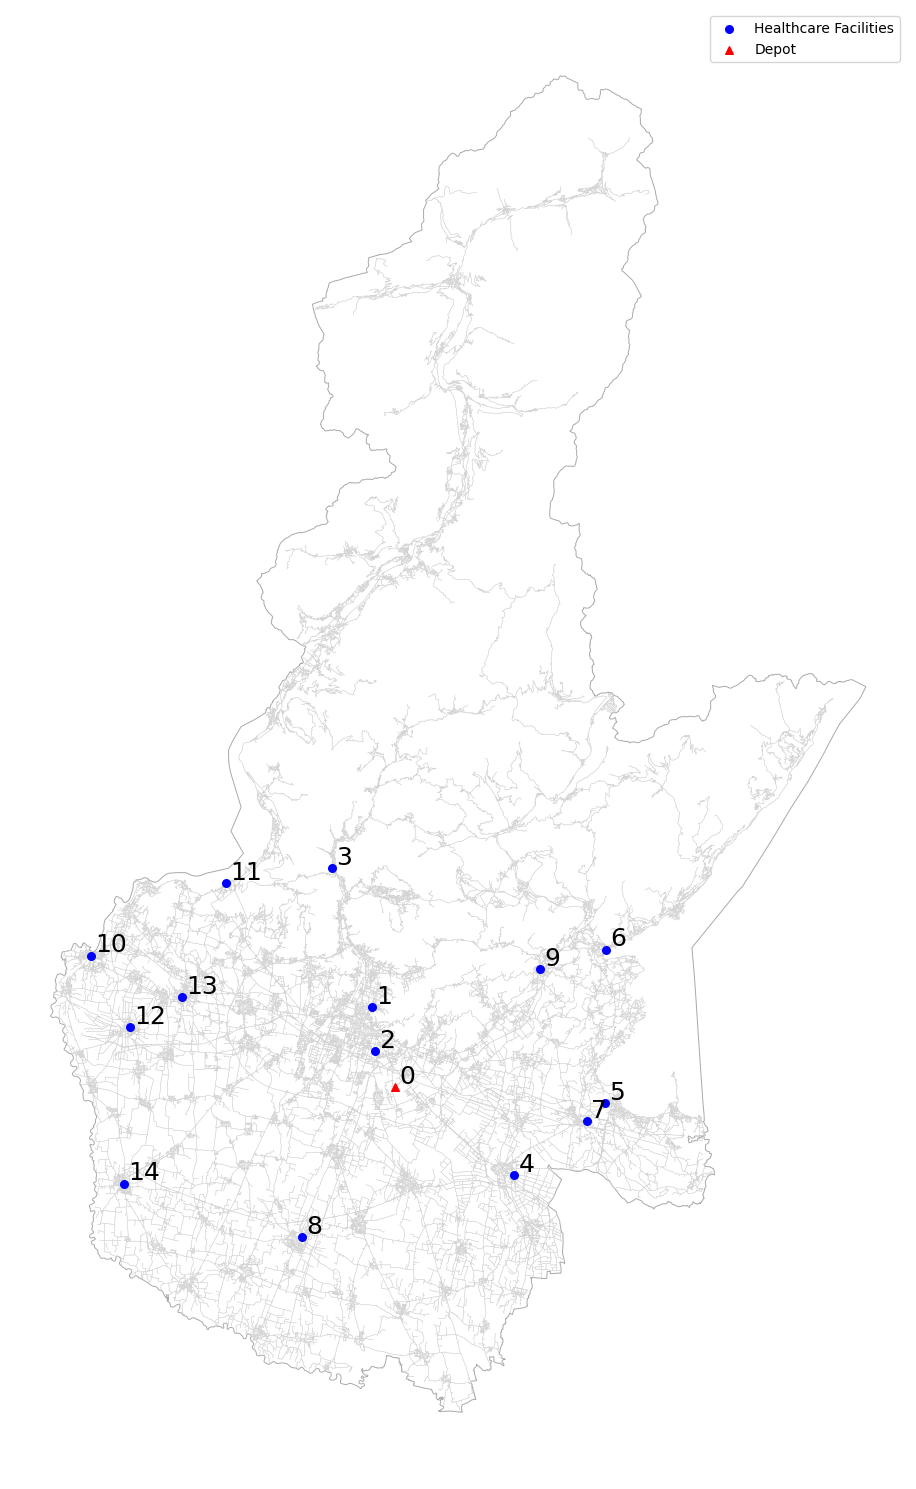

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# Dati
lats = [45.5557508, 45.5173032, 45.6752766, 45.4104244, 45.4724484, 45.6052090,
        45.4570527, 45.3564514, 45.5886191, 45.6000908, 45.6629423, 45.5380671,
        45.5643032, 45.4027300]
lons = [10.2333866, 10.2367065, 10.1838538, 10.4087873, 10.5210075, 10.5222784,
        10.4981922, 10.1459897, 10.4399889, 9.8859103, 10.0521876, 9.9340234,
        9.9981402, 9.9265984]

# Nomi degli ospedali (approssimati)
hospital_names = [
    "Ospedale Civile di Brescia (ASST Brescia)",
    "Poliambulanza",
    "Ospedale di Gardone Val Trompia(ASST Brescia)",
    "Ospedale di Montichiari (ASST Brescia)",
    "Ospedale di Desenzano del Garda(ASST del Garda)",
    "Ospedale di Salo (ASST del Garda)",
    "Ospedale di Lonato del Garda (ASST del Garda)",
    "Ospedale di Manerbio (ASST Garda)",
    "Ospedale di Gavardo (ASST del Garda)",
    "Ospedale di Palazzolo sull'Oglio (ASST Franciacorta)",
    "Ospedale di Iseo (ASST Franciacorta)",
    "Ospedale di Chiari (ASST Franciacorta)",
    "Ospedale di Rovato (ASST Franciacorta)",
    "Ospedale di Orzinuovi(ASST Franciacorta)"
]

ids = list(range(1, 15))

depot_lat = 45.486074
depot_lon = 10.261607

# Crea geometrie
facility_points = [Point(lon, lat) for lon, lat in zip(lons, lats)]
depot_point = Point(depot_lon, depot_lat)

# Crea GeoDataFrame
facilities_gdf = facilities_gdf = gpd.GeoDataFrame({
    'ID': ids,
    'Name': hospital_names,
    'geometry': facility_points
}, crs="EPSG:4326").to_crs(epsg=3857)


depot_gdf = gpd.GeoDataFrame({
    'ID': [0],
    'Name': ['Depot'],
    'geometry': [Point(depot_lon, depot_lat)]
}, crs="EPSG:4326").to_crs(epsg=3857)

# Unisci se ti serve avere un unico GDF
all_nodes_gdf = pd.concat([depot_gdf, facilities_gdf], ignore_index=True)
# Crea la mappa
fig, ax = plt.subplots(figsize=(15, 15))

province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7)

# Plotta le strade (supponendo EPSG:3857)
roads_gdf.to_crs(epsg=3857).plot(ax=ax, color='lightgrey', linewidth=0.3)

# Plotta i punti (strutture sanitarie)
facilities_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='Healthcare Facilities',zorder=2)

for idx, row in facilities_gdf.iterrows():
    ax.annotate(text=str(row['ID']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=18, color='black')

ax.annotate(text='0', xy=(depot_gdf.geometry.x[0], depot_gdf.geometry.y[0]),
            xytext=(3, 3), textcoords="offset points", fontsize=18, color='black')

# Plotta il deposito come stellina rossa
depot_gdf.plot(ax=ax, color='red', marker='^', markersize=30, label='Depot',zorder=2)

# Titolo e layout
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
facilities_gdf

ID                                               Name  \
0    1          Ospedale Civile di Brescia (ASST Brescia)   
1    2                                      Poliambulanza   
2    3      Ospedale di Gardone Val Trompia(ASST Brescia)   
3    4             Ospedale di Montichiari (ASST Brescia)   
4    5    Ospedale di Desenzano del Garda(ASST del Garda)   
5    6                  Ospedale di Salo (ASST del Garda)   
6    7      Ospedale di Lonato del Garda (ASST del Garda)   
7    8                  Ospedale di Manerbio (ASST Garda)   
8    9               Ospedale di Gavardo (ASST del Garda)   
9   10  Ospedale di Palazzolo sull'Oglio (ASST Francia...   
10  11               Ospedale di Iseo (ASST Franciacorta)   
11  12             Ospedale di Chiari (ASST Franciacorta)   
12  13             Ospedale di Rovato (ASST Franciacorta)   
13  14           Ospedale di Orzinuovi(ASST Franciacorta)   

                           geometry  
0   POINT (1139175.385 5709441.548)  
1   POINT (1139544.955 5703331.276)  
2   POINT (1133661.419 5728463.896)  
3   POINT (1158700.902 5686367.496)  
4   POINT (1171193.198 5696208.015)  
5   POINT (1171334.673 5717307.828)  
6    POINT (1168653.41 5693764.375)  
7   POINT (1129446.407 5677813.112)  
8   POINT (1162174.248 5714668.448)  
9   POINT (1100494.501 5716493.462)  
10  POINT (1119004.405 5726499.033)  
11  POINT (1105850.426 5706630.653)  
12  POINT (1112987.876 5710801.304)  
13  POINT (1105023.879 5685147.482)

In [ ]:
all_nodes_gdf

ID                                               Name  \
0    0                                              Depot   
1    1          Ospedale Civile di Brescia (ASST Brescia)   
2    2                                      Poliambulanza   
3    3      Ospedale di Gardone Val Trompia(ASST Brescia)   
4    4             Ospedale di Montichiari (ASST Brescia)   
5    5    Ospedale di Desenzano del Garda(ASST del Garda)   
6    6                  Ospedale di Salo (ASST del Garda)   
7    7      Ospedale di Lonato del Garda (ASST del Garda)   
8    8                  Ospedale di Manerbio (ASST Garda)   
9    9               Ospedale di Gavardo (ASST del Garda)   
10  10  Ospedale di Palazzolo sull'Oglio (ASST Francia...   
11  11               Ospedale di Iseo (ASST Franciacorta)   
12  12             Ospedale di Chiari (ASST Franciacorta)   
13  13             Ospedale di Rovato (ASST Franciacorta)   
14  14           Ospedale di Orzinuovi(ASST Franciacorta)   

                           geometry  
0   POINT (1142316.866 5698371.257)  
1   POINT (1139175.385 5709441.548)  
2   POINT (1139544.955 5703331.276)  
3   POINT (1133661.419 5728463.896)  
4   POINT (1158700.902 5686367.496)  
5   POINT (1171193.198 5696208.015)  
6   POINT (1171334.673 5717307.828)  
7    POINT (1168653.41 5693764.375)  
8   POINT (1129446.407 5677813.112)  
9   POINT (1162174.248 5714668.448)  
10  POINT (1100494.501 5716493.462)  
11  POINT (1119004.405 5726499.033)  
12  POINT (1105850.426 5706630.653)  
13  POINT (1112987.876 5710801.304)  
14  POINT (1105023.879 5685147.482)

In [ ]:
#Trova i nodi più vicini per ogni punto
#Ricostruisci nodi da valid_roads_gdf
node_coords = {}

for _, row in valid_roads_gdf.iterrows():
    start = row['geometry'].coords[0]
    end = row['geometry'].coords[-1]
    node_coords[row['u']] = Point(start)
    node_coords[row['v']] = Point(end)

nodes_gdf = gpd.GeoDataFrame(
    {'osmid': list(node_coords.keys()), 'geometry': list(node_coords.values())},
    crs=valid_roads_gdf.crs
)

poi_nodes = []
for point in all_nodes_gdf.geometry:
    distances = nodes_gdf.geometry.distance(point)
    closest_node = nodes_gdf.iloc[distances.idxmin()]['osmid']
    poi_nodes.append(closest_node)


In [ ]:
# Matrice dei costi conindice = ID ospedali (0 = deposito)
n = len(poi_nodes)
cost_matrix = pd.DataFrame(index=all_nodes_gdf['ID'], columns=all_nodes_gdf['ID'])
#cost_matrix = pd.DataFrame(index=range(n), columns=range(n))

#DIJKSTRA ALGORITHM
for i, source in enumerate(poi_nodes):
    lengths = nx.single_source_dijkstra_path_length(G, source, weight='weight')
    for j, target in enumerate(poi_nodes):
        cost = lengths.get(target, float('inf'))
        cost_matrix.iloc[i, j] = cost


In [ ]:
cost_matrix

ID           0            1            2            3            4   \
ID                                                                    
0             0   885.717084   472.455968  1862.020744  1219.726673   
1    888.530727            0   505.799083  1152.350558  1825.097427   
2    480.252447   488.290779            0  1585.720997  1433.513545   
3    1866.23297  1122.451598  1628.250681            0   2770.39484   
4    1425.60509  1966.583763  1553.808207  2871.600022            0   
5   1333.036139   1738.17253  1324.911414  2643.945282  1024.007893   
6   1557.019495  2020.995139  1685.222611  2908.069578  2025.242235   
7   1356.902341  1762.038732  1348.777616  2667.811485   680.629814   
8   1217.240212  1435.159492  1021.898376  2427.653635   1722.73147   
9   1192.951034  1656.926678   1321.15415  2530.317995  1711.381646   
10  1781.769072  1709.657154   1574.77688  2077.307579  2578.902906   
11  1459.143283  1450.860318  1252.151091  1066.191771  2387.843109   
12  1491.565432   1561.04212  1362.332894  2055.174054  2052.509981   
13  1341.627845  1269.515927  1134.635654  1637.166352  2023.609166   
14  2059.394517  2308.856563  2182.749951  2902.780707  2620.339066   

ID           5            6            7            8            9   \
ID                                                                    
0   1396.683926  1604.608094  1391.365292  1281.954377   1232.06759   
1   1767.349463  2058.683063  1792.917344  1628.851349  1686.142558   
2   1338.470401  1768.360591  1364.038282  1199.972287  1395.820086   
3   2721.572651  2939.916758  2747.140532  2642.440681  2523.502914   
4   1030.029285  1939.043183    680.76245   1736.99017  1903.972628   
5             0  1259.108539   496.220155  2168.127499  1594.338273   
6   1343.861027            0  1497.454496  2589.736887   640.819134   
7    499.631998  1408.645896            0  2191.993701  1478.373518   
8   1855.797626  2435.356351  1881.365508            0  2062.815846   
9   1562.416523   631.051175  1506.079742  2225.668426            0   
10  2400.923403  2980.482127  2426.491284  2324.710324  2607.941623   
11  2310.565051  2722.690155  2336.132932  2234.351972  2350.149651   
12  2269.047762  2810.202313  2294.615644  2008.375972  2437.661809   
13  1960.782176  2540.340901  1986.350057  1884.569097  2167.800396   
14  3022.870679  3378.031399  3048.438561  1368.190268  3005.490894   

ID           10           11           12           13           14  
ID                                                                   
0   1757.198982  1612.472693  1533.667364   1332.69525  2004.701189  
1    1609.97842  1517.783247  1487.916088  1185.474688  2311.899021  
2   1417.233612  1336.172946   1295.17128    992.72988  2151.692527  
3   2009.888081   1108.18881  2012.534766  1585.384349  2896.148387  
4   2645.238265  2622.051971  2339.963433  2220.734532  2810.997258  
5   2323.184402  2356.713036   2201.12207  1898.680669  2983.347534  
6   2860.566388  2753.466375  2738.504056  2436.062655    3312.4837  
7   2347.050604  2380.579238  2224.988272  1922.546872  3007.213736  
8   2127.613964  2161.142598  1964.954997  1703.110232  1384.831974  
9   2496.497927  2389.397915  2374.435595  2071.994195  2948.415239  
10            0  1535.848057   758.815465   843.914712  1815.614108  
11  1558.598863            0  1566.194635  1139.044217  2449.808256  
12    784.17816  1588.438891            0   451.788934  1313.423524  
13   826.385437  1155.248518   439.214294            0  1731.051136  
14  1832.857121  2512.706188  1303.985432  1735.063083            0

In [ ]:
#salvarlo su excel
cost_matrix.to_csv("vrp_cost_matrix.csv", index=True)#it will be added manually to the excel file

# Mappe con i percorsi risolti con il VRP


In [ ]:
#At this point, the input data can be collected in the excel file (cost matrix, daily waste production). 
#Now the code "VRP accumulated demand B" needs to be run: it contains the definition of the parameters, sets, decision variables, objective functions and constraints.
#The following section can be run after the model has been solved and the purpose is just to graphically display the optimal routes found by the model.

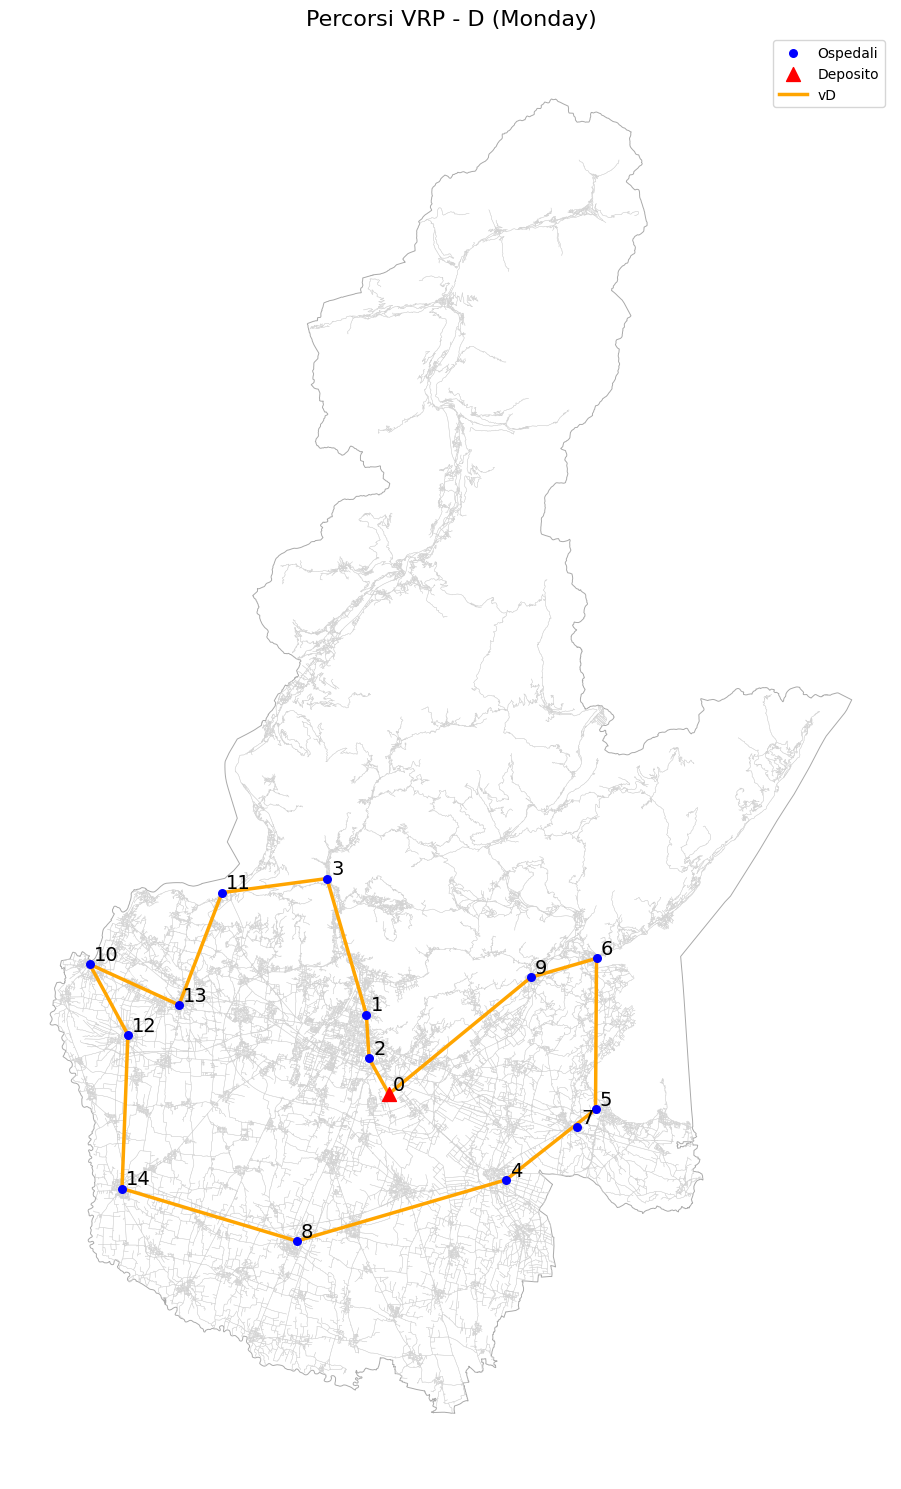

In [ ]:
# Percorso categoria D
route_d = [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 5, 6, 9, 0] #manually extracted from the other model's solution
points_d = [all_nodes_gdf.loc[all_nodes_gdf['ID'] == node, 'geometry'].values[0] for node in route_d]
route_d_gdf = gpd.GeoDataFrame([{'vehicle': 'vD', 'geometry': LineString(points_d)}], crs=all_nodes_gdf.crs)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, zorder=0)
roads_gdf.to_crs(epsg=3857).plot(ax=ax, color='lightgrey', linewidth=0.3, zorder=1)

facilities_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='Ospedali', zorder=3)
depot_gdf.plot(ax=ax, color='red', marker='^', markersize=100, label='Deposito', zorder=4)

# Annotazioni
for idx, row in all_nodes_gdf.iterrows():
    ax.annotate(text=str(row['ID']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=14, color='black')

# Linea percorso
ax.plot(*route_d_gdf.iloc[0]['geometry'].xy, color='orange', linewidth=2.5, label='vD', zorder=2)

# Legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

ax.set_title("Percorsi VRP - D (Monday)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("Percorsi VRP - D (Monday).png", dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
from google.colab import files
files.download('Percorsi VRP - D (Monday).png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

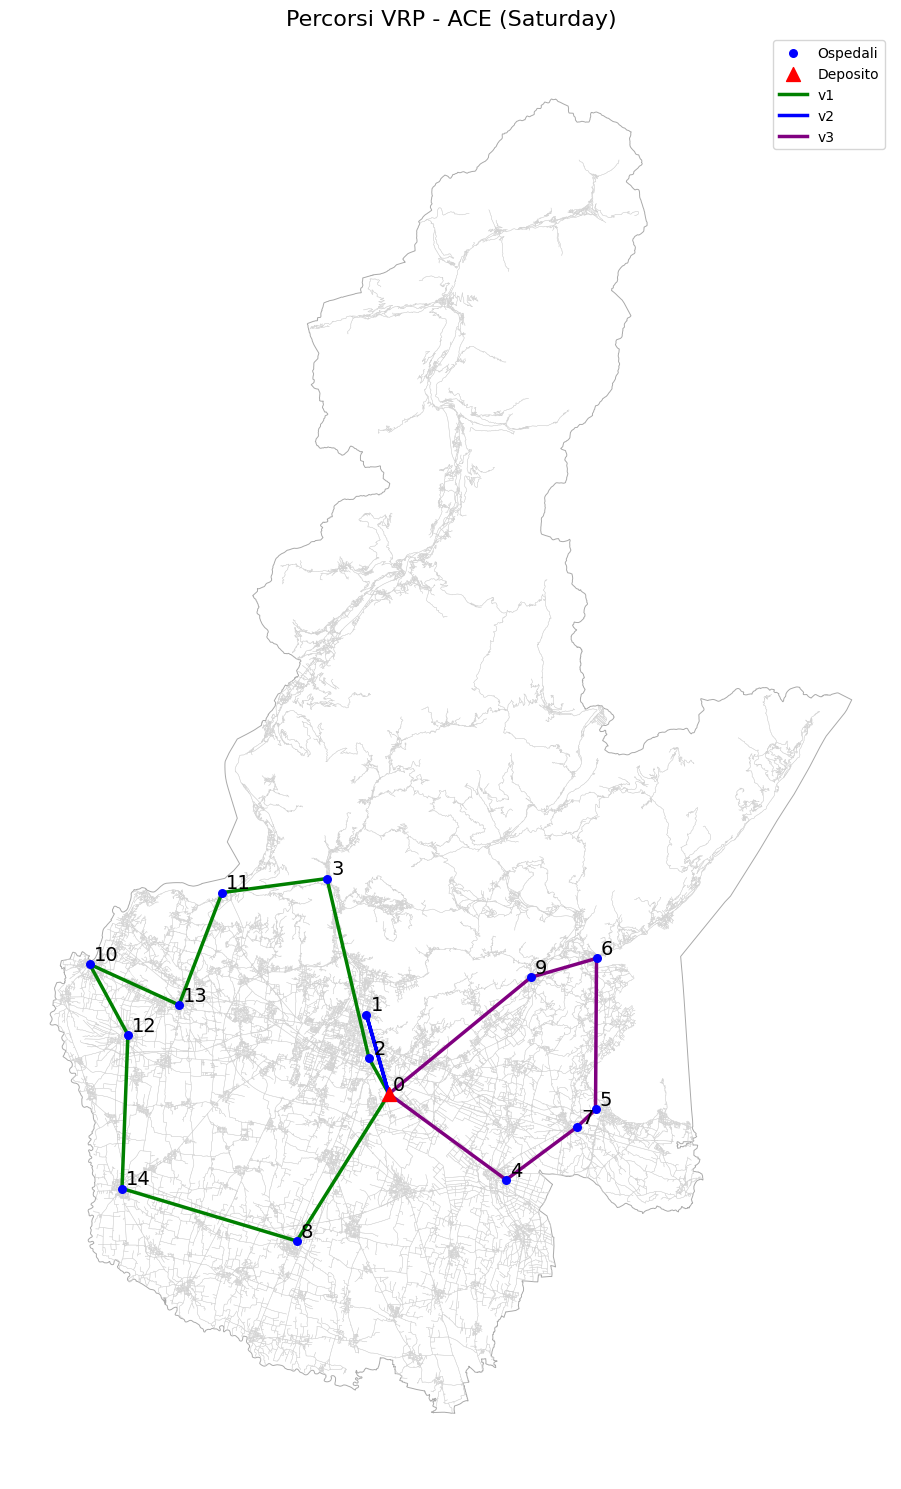

In [ ]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# Percorsi ACE - Saturday #manually extracted from the other model's solution
routes_sat = {
    "v1": [0, 8, 14, 12, 10, 13, 11, 3, 2, 0],
    "v2": [0, 1, 0],
    "v3": [0, 4,7,5, 6, 9, 0]
}
colors_sat = {"v1": "green", "v2": "blue", "v3": "purple"}

# Costruisci le linee
route_lines_sat = []
for vehicle, path in routes_sat.items():
    points = [all_nodes_gdf.loc[all_nodes_gdf['ID'] == node, 'geometry'].values[0] for node in path]
    line = LineString(points)
    route_lines_sat.append({'vehicle': vehicle, 'geometry': line, 'color': colors_sat[vehicle]})
routes_sat_gdf = gpd.GeoDataFrame(route_lines_sat, crs=all_nodes_gdf.crs)

# Plot con sfondo
fig, ax = plt.subplots(figsize=(15, 15))
province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, zorder=0)
roads_gdf.to_crs(epsg=3857).plot(ax=ax, color='lightgrey', linewidth=0.3, zorder=1)
facilities_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='Ospedali', zorder=3)
depot_gdf.plot(ax=ax, color='red', marker='^', markersize=100, label='Deposito', zorder=4)

# Annotazioni
for idx, row in all_nodes_gdf.iterrows():
    ax.annotate(text=str(row['ID']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=14, color='black')

# Traccia le rotte
for _, row in routes_sat_gdf.iterrows():
    ax.plot(*row['geometry'].xy, color=row['color'], linewidth=2.5, label=row['vehicle'], zorder=2)

# Legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

ax.set_title("Percorsi VRP - ACE (Saturday)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("Percorsi VRP - ACE (Saturday).png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from google.colab import files
files.download('Percorsi VRP - ACE (Saturday).png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

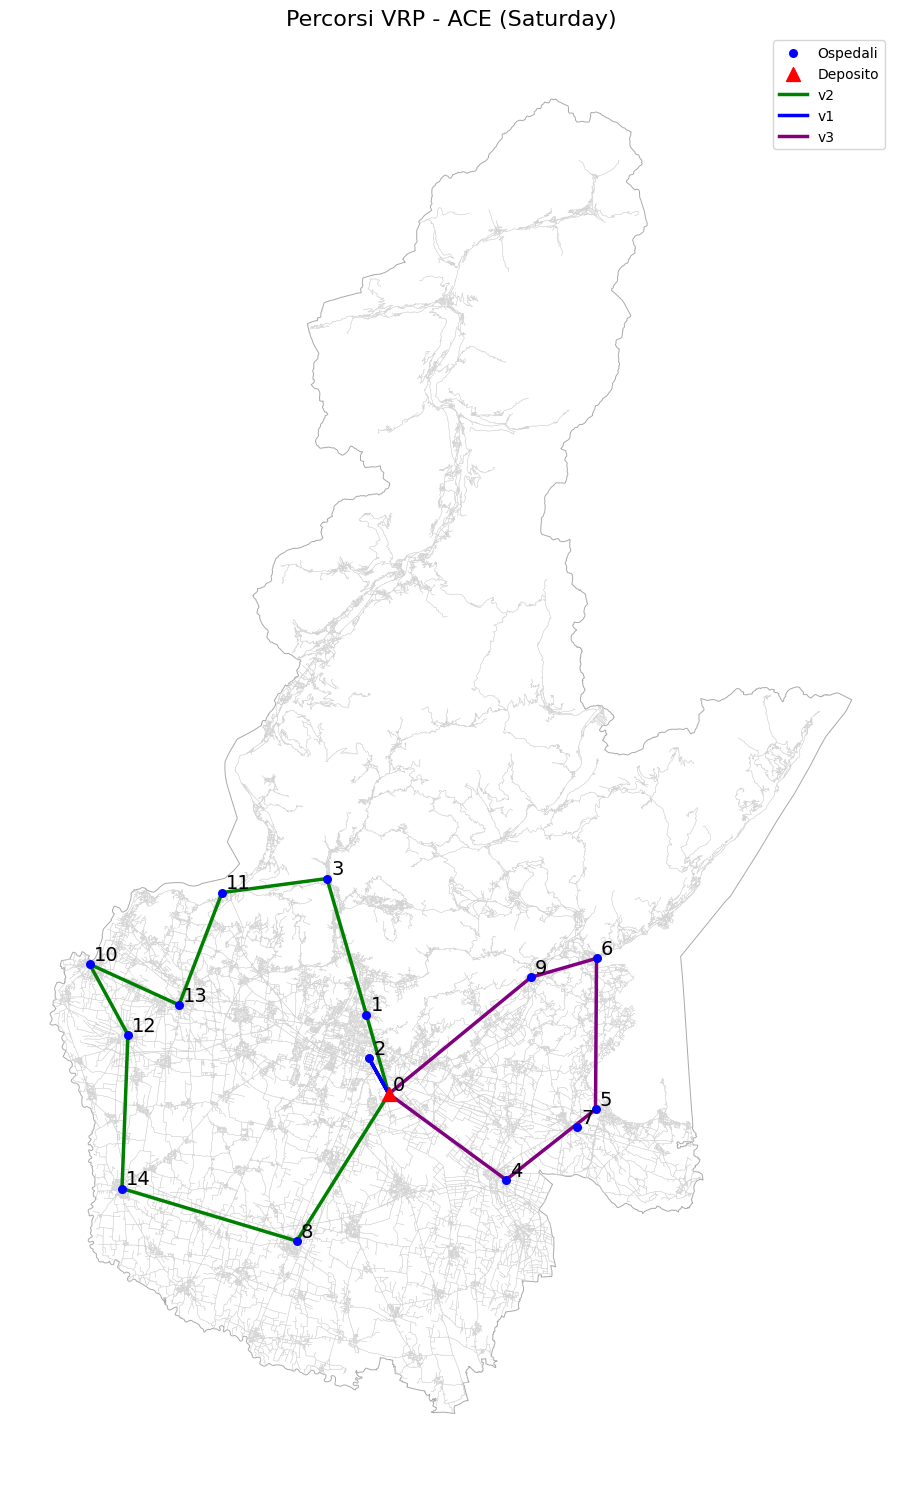

In [ ]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# Percorsi ACE - Saturday #manually extracted from the other model's solution
routes_sat = {
    "v2": [0, 8, 14, 12, 10, 13, 11, 3, 1, 0],     # verde
    "v1": [0, 2, 0],                               # blu
    "v3": [0, 4, 5, 6, 9, 0]                       # viola
}
colors_sat = {"v1": "blue", "v2": "green", "v3": "purple"}

# Crea le linee
route_lines_sat = []
for vehicle, path in routes_sat.items():
    points = [all_nodes_gdf.loc[all_nodes_gdf['ID'] == node, 'geometry'].values[0] for node in path]
    line = LineString(points)
    route_lines_sat.append({'vehicle': vehicle, 'geometry': line, 'color': colors_sat[vehicle]})
routes_sat_gdf = gpd.GeoDataFrame(route_lines_sat, crs=all_nodes_gdf.crs)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7, zorder=0)
roads_gdf.to_crs(epsg=3857).plot(ax=ax, color='lightgrey', linewidth=0.3, zorder=1)
facilities_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='Ospedali', zorder=3)
depot_gdf.plot(ax=ax, color='red', marker='^', markersize=100, label='Deposito', zorder=4)

# Annotazioni nodi
for idx, row in all_nodes_gdf.iterrows():
    ax.annotate(text=str(row['ID']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=14, color='black')

# Disegna rotte
for _, row in routes_sat_gdf.iterrows():
    ax.plot(*row['geometry'].xy, color=row['color'], linewidth=2.5, label=row['vehicle'], zorder=2)

# Legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

# Titolo e salvataggio
ax.set_title("Percorsi VRP - ACE (Saturday)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.savefig("percorsi_vrp_ace_saturday.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from google.colab import files
files.download("percorsi_vrp_ace_saturday.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>